# MFE 230J Project 3 - Cryptocurrency Returns & Trading Venues

Renee Reynolds  
23 February 2021

### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import log10, floor
from scipy.stats import chi2_contingency

In [2]:
sns.set()

### Functions

In [3]:
def plot_volume(data, coin, time_freq, time_freq_title):
    """
    Plots a single time series of volume at given time frequency 
    for given cryptocurrency
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data
    coin : str
        Cryptocurrency ticker to plot time series volumes of
    time_freq : str
        Time frequency to resample and plot (e.g. 'H' or 'D')
    time_freq_title : str
        Name of time frequency to use in plot title (e.g. 'hourly' or 'daily')

    Returns
    -------
    None
    """
    data.set_index('date_time')\
        .groupby('Exchange')\
        .resample(time_freq).sum()\
        .reset_index()\
        .set_index('date_time')\
        .groupby('Exchange')['volume']\
        .plot(legend=True, figsize=(18,5),
              xlabel='date', ylabel='volume',
              title='Time series of {} {} volume by exchange'.format(time_freq_title, coin))
    plt.show()


def wrapper_plot_volumes(data, coin):
    """
    Plots time series of volumes for given cryptocurrency at various time frequencies
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data
    coin : str
        Cryptocurrency ticker to plot time series volumes of
    
    Returns
    -------
    None
    """
    df = data[data['Coin'] == coin]
    
    time_freq_dict = {'H':'hourly',
                      'D':'daily',
                      'M':'monthly',
                      'Q':'quarterly',
                      'A':'annual'}

    for k in time_freq_dict.keys():
        plot_volume(df, coin, k, time_freq_dict[k])
    

def display_side_by_side(dfs:list, captions:list):
# source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


def calc_overall_volume_by_exchange(data, coin, fn, isDaily=False, time_freq=''):
    """
    Calculates overall volume for given cryptocurrency at (optional) given time frequency
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data 
    coin : str
        Cryptocurrency ticker to calculate volumes of
    fn : str
        Aggregation function (mean or sum) for volumes
    isDaily : boolean, optional
        Flag indicating whether to calculate daily volumes (default is False)
    time_freq : str, optional
        Time frequency (e.g. 'year') at which to calculate volume (default is '', or hourly)

    Returns
    -------
    DataFrame
        volumes of given cryptocurrency at given time frequency
    """
    df_stats = data[data['Coin']==coin]
    
    if isDaily:
        df_stats = df_stats.set_index('date_time')\
                           .groupby(['Coin', 'Exchange'])\
                           .resample('D').sum()[['volume']]
    
    if time_freq != '':
        df_stats = df_stats.groupby([time_freq, 'Coin', 'Exchange'])\
                           .sum()[['volume']]\
                           .reset_index()\
                           .set_index([time_freq, 'Coin'])\
                           .sort_index()
    else:
        df_stats = df_stats.groupby(['Coin','Exchange'])\
                           .agg({'volume':fn})[['volume']]\
                           .sort_values('volume', ascending=False)
    
    return df_stats


def plot_volume_by_time_freq(data, coin, time_freq, xrange, xlabels):
    """
    Plots a single bar graph of volumes of the given cryptocurrency at the 
    given time frequency
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data
    coin : str
        Cryptocurrency ticker to plot volumes of
    time_freq : str
        Time frequency to plot (e.g. 'year')
    xrange : array
        Location to place x axis labels
    xlabels : array or list
        Labels to place on x axis

    Returns
    -------
    None
    """
    exchanges = ['Bitstamp','Bittrex','Coinbase','Gemini','Kraken']
    offsets = np.arange(-0.2, 0.3, 0.1)
    bar_width = 0.1
    
    df = calc_overall_volume_by_exchange(data, coin, 'sum', isDaily=False, time_freq=time_freq)
    
    plt.figure(figsize=(18,6))
    for i in range(len(exchanges)):
        plt.bar(xrange + offsets[i],
                df[df['Exchange'] == exchanges[i]]['volume'], 
                label=exchanges[i], width=bar_width)
    plt.xticks(xrange, xlabels)
    plt.title('Total {} {} volume by exchange'.format(time_freq, coin))
    plt.xlabel('date')
    plt.ylabel('volume')
    plt.legend()
    plt.show()
    

def plot_overall_volume_by_exchange(data, coin):
    """
    Plots volumes of given cryptocurrency 
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data
    coin : str
        Cryptocurrency ticker to plot volumes of

    Returns
    -------
    None
    """
    # bar plots: total volume, average hourly volume, average daily volume by exchange
    df_sum = calc_overall_volume_by_exchange(data, coin, 'sum', isDaily=False)
    df_mean = calc_overall_volume_by_exchange(data, coin, 'mean', isDaily=False)
    df_mean_daily = calc_overall_volume_by_exchange(data, coin, 'mean', isDaily=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
    ax1.bar(df_sum.index.get_level_values('Exchange'), 
            df_sum['volume'],  
            width=0.3)
    ax1.set_title('Total {} volume'.format(coin))
    ax2.bar(df_mean.index.get_level_values('Exchange'), 
            df_mean['volume'], 
            width=0.3,
            color='orange')
    ax2.set_title('Average {} {} volume'.format('hourly', coin))
    ax3.bar(df_mean_daily.index.get_level_values('Exchange'), 
            df_mean_daily['volume'], 
            width=0.3,
            color='green')
    ax3.set_title('Average {} {} volume'.format('daily', coin))
    plt.show()
    display_side_by_side([df_sum, df_mean, df_mean_daily], 
                         ['Total Overall {} Volume'.format(coin), 
                          'Average Hourly Overall {} Volume'.format(coin),
                          'Average Daily Overall {} Volume'.format(coin)])
    
    # bar plots: total volume per year, month, and day of week by exchange
    day_of_week_order = data[['day_of_week','day_of_week_name']].drop_duplicates()\
                                                                .sort_values('day_of_week')['day_of_week_name']
    time_freq_dict = {'year': [np.arange(2014, 2020), np.arange(2014, 2020)],
                      'month': [np.arange(1,13), ['Jan','Feb','Mar','Apr','May','Jun',
                                                  'Jul','Aug','Sep','Oct','Nov','Dec']],
                      'day_of_week': [np.arange(7), day_of_week_order]}
    
    for t in time_freq_dict.keys():
        plot_volume_by_time_freq(data, coin, t, time_freq_dict[t][0], time_freq_dict[t][1])
        

def plot_log_returns(data, col, name, pivot_col):
    """
    Plots hourly log returns for given cryptocurrency or exchange
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing log returns data
    col : str
        Column (either 'Coin' or 'Exchange') to plot log returns of
    name : str
        Specific cryptocurrency or exchange to plot log returns of (e.g. 'BTC' or 'Coinbase')
    pivot_col : str
        Opposite of col (either 'Exchange' or 'Coin'); plot log returns of name by exchange
        if name is a cryptocurrency, and plot log returns of name by cryptocurrency if name
        is an exchange

    Returns
    -------
    None
    """
    df = data[data[col] == name].drop([col, 'close', 'close_lag1'], axis=1)\
                                .dropna()\
                                .pivot(index='date_time',
                                       columns=pivot_col,
                                       values='log_returns')
    ax = df.plot(figsize=(18, df.shape[1]*5),
                 subplots=True,
                 sharex=False,
                 xlim=('2014-07-01', '2019-08-15'),
                 title='Log returns of {} by {}'.format(name, pivot_col.lower()),
                 xlabel='date',
                 ylabel='log returns (%)')[0]
    fig = ax.get_figure()
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()            


def plot_log_returns_by_coin(data):
    """
    Plots hourly log returns for each cryptocurrency by exchange
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing log returns data

    Returns
    -------
    None
    """
    coins_list = data['Coin'].sort_values().unique()
    
    for c in coins_list:
        plot_log_returns(data, 'Coin', c, 'Exchange')
    

def plot_log_returns_by_exchange(data):
    """
    Plots hourly log returns for each exchange by cryptocurrency
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing log returns data

    Returns
    -------
    None
    """
    exchanges_list = data['Exchange'].sort_values().unique()
    
    for ex in exchanges_list:
        plot_log_returns(data, 'Exchange', ex, 'Coin')

        
def plot_split(data, col, coin, start, end):
    """
    Plots hourly time series of either closing price or log returns of the given
    cryptocurrency over the given date range for each exchange
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing log returns data
    col : str
        Characteristic to plot (i.e. 'close' or 'log_returns')
    coin : str
        Cryptocurrency ticker to plot time series of
    start : str
        Start date of plot date range
    end : str
        End date of plot date range

    Returns
    -------
    None
    """
    data[(data['Coin']==coin) & 
         (data['date_time'] >= start) &
         (data['date_time'] <= end)][['date_time', 'Exchange', col]].pivot(index='date_time',
                                                                           columns='Exchange',
                                                                           values=col)\
                                                                    .plot(subplots=True, 
                                                                          sharex=False, 
                                                                          layout=(5,1),
                                                                          figsize=(12,14),
                                                                          title='{} {} from {} to {}'.format(coin, 
                                                                                                             col, 
                                                                                                             start, 
                                                                                                             end))
    plt.subplots_adjust(hspace=0.7)
    plt.show()

    
def wrapper_plot_split(data, coin, start, end):
    """
    Plots hourly time series of both closing price and log returns of the given
    cryptocurrency over the given date range for each exchange
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing log returns data
    coin : str
        Cryptocurrency ticker to plot time series of
    start : str
        Start date of plot date range
    end : str
        End date of plot date range

    Returns
    -------
    None
    """
    plot_split(data, 'close', coin, start, end)
    plot_split(data, 'log_returns', coin, start, end)
        
        
def read_and_prep_csv(csv_file):
    """
    Reads in and preprocesses the given csv file (data source: yahoo finance)
    
    Parameters
    ----------
    csv_file : str
        Name of csv file to read in and preprocess (csv_file string should 
        exclude '.csv' extension)

    Returns
    -------
    DataFrame
        preprocessed data from csv_file
    """
    df = pd.read_csv(csv_file + '.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Adj Close':csv_file,
                       'Date':'date_time'}, inplace=True)
    
    return df[['date_time', csv_file]]

        
def create_rf_data(df, col, nlags=7):
    """
    Transforms time series data for running supervised random forest model
    
    Parameters
    ----------
    df : DataFrame
        Training data containing log returns
    col : str
        Cryptocurrency ticker to use in strategy
    nlags : int, optional
        Number of lags to use in random forest model (default is 7 as currencies are a 24hr market)

    Returns
    -------
    DataFrame
        transformed training data containing a column for each of the given number of lags
    """
    df_rf = df[[col]].copy()
    
    for i in range(1,nlags+1):
        df_rf[col+'_t-'+str(i)] = df_rf[col].shift(i)
    
    df_rf.dropna(inplace=True)
    
    return df_rf


def fit_rf_model(X, y):
    """
    Fits random forest model using given X and y inputs
    
    Parameters
    ----------
    X : DataFrame
        Transformed training data (contains log returns for specified number of lags)
    y : array
        Log returns (lag 0) of given cryptocurrency ticker
        
    Returns
    -------
    RandomForestRegressor model object
        random forest model fit to transformed training data (X and y)
    """
    model = RandomForestRegressor()
    model.fit(X.values, y.values)
    return model


def predict_rf_returns(df, col, nlags=7):
    """
    Runs random forest model and creates signal (i.e. buy if 
    random forest prediction > previous day's return) 
    
    Parameters
    ----------
    df : DataFrame
        Training data containing log returns
    col : str
        Cryptocurrency ticker to use in strategy
    nlags : int, optional
        Number of lags to use in random forest model (default is 7 as currencies are a 24hr market)

    Returns
    -------
    DataFrame
        transformed training data (for running random forest model), also 
        contains predictions and signals
    float
        MSE of random forest model on training data
    RandomForestRegressor model object
        random forest model fit to training data
    """
    df_rf = create_rf_data(df, col, nlags)
    X = df_rf.drop([col], axis=1)
    y = df_rf[col]
    rf_model = fit_rf_model(X, y)
    df_rf['rf_pred'] = rf_model.predict(X)
    df_rf['signal'] = np.where(df_rf.rf_pred > df_rf[col+'_t-1'], 1, -1)
    rf_mse = mean_squared_error(df_rf[col], df_rf.rf_pred)
    return df_rf, rf_mse, rf_model


def print_rf_results(df, df_test, col, nlags=7):
    """
    Displays results/plots of strategy using random forest predictions
    
    Parameters
    ----------
    data : DataFrame
        Training data containing log returns
    df_test : DataFrame
        Test dataset containing log returns
    col : str
        Cryptocurrency ticker to use in strategy
    nlags : int, optional
        Number of lags to use in random forest model (default is 7 as currencies are a 24hr market)

    Returns
    -------
    None
    """
    df_rf, rf_mse, rf_model = predict_rf_returns(df, col, nlags)
    df_rf_test = create_rf_data(df_test, col, nlags)
    X_test = df_rf_test.drop([col], axis=1)
    y_test = df_rf_test[col]
    df_rf_test['rf_pred'] = rf_model.predict(X_test)
    df_rf_test['signal'] = np.where(df_rf_test.rf_pred > df_rf_test[col+'_t-1'], 1, -1)
    rf_mse_test = mean_squared_error(df_rf_test[col], df_rf_test.rf_pred)
    display(df_rf.head())
    print('Random forest regression training MSE: {}'.format(rf_mse))
    print('Random forest regression test MSE: {}'.format(rf_mse_test))
    
    daily_return = df_rf.signal * df_rf[col]
    daily_return_test = df_rf_test.signal * df_rf_test[col]
    ax = daily_return.plot(figsize=(16,6), 
                           label='train',
                           title='Random Forest {} Strategy Daily Returns'.format(col))
    daily_return_test.plot(ax=ax, 
                           color='orange',
                           label='test')
    plt.legend()
    plt.show()
    
    cum_return = (daily_return + 1).cumprod()
    cum_return.plot(figsize=(16,4),
                    title='Random Forest {} Strategy Cumulative Returns - Train'.format(col))
    plt.show()
    
    cum_return_test = (daily_return_test + 1).cumprod()
    ax = cum_return_test.plot(figsize=(16,4),
                              label='strategy',
                              color='orange',
                              title='Random Forest {} Strategy Cumulative Returns - Test'.format(col))
    (df_test[col] + 1).cumprod()\
                      .plot(ax=ax,
                            label=col,
                            color='green')
    plt.legend()
    plt.show()
    
    ax = cum_return_test.plot(figsize=(16,6),
                              label='strategy',
                              color='orange',
                              title='Random Forest {} Strategy Cumulative Returns - Test'.format(col))
    (df_test[['BTC','ETH','S&P500','VIX','GOLD','EURUSD']] + 1).cumprod().plot(ax=ax)
    plt.legend()
    plt.show()


def plot_top5_coinbase_volume(data, coins, start, end):
    """
    Plots hourly volume of given coins on Coinbase exchange between start 
    and end date/time values
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data
    coins : list
        List of strings indicating cryptocurrency ticker names to plot
    start : str
        Start date of plot date range
    end : str
        End date of plot date range

    Returns
    -------
    None
    """
    data[(data.Coin.isin(coins)) &
         (df.Exchange=='Coinbase') &
         (df.date_time >= start) &
         (df.date_time <= end)][['date_time','Coin','volume']].pivot(index='date_time',
                                                                     columns='Coin',
                                                                     values='volume')\
                                                              .plot(figsize=(14,16),
                                                                    sharex=False,
                                                                    subplots=True,
                                                                    title='Hourly volume from {} to {}'.format(start, end))
    plt.subplots_adjust(hspace=0.7)
    plt.show()
    

# sources: https://jheusser.github.io/2014/04/18/benfords-law.html
#          https://github.com/jheusser/benford/blob/master/bf.py
#          http://www.johndcook.com/blog/2011/10/19/benfords-law-and-scipy/

def most_significant_digit(x):
    """
    Get most significant (i.e. leading) digit of given number
    
    Parameters
    ----------
    x : float
        Number to find most significant digit of

    Returns
    -------
    int
        returns integer of the most significant digit
    """
    e = floor(log10(x))
    return int(x*10**-e)


def chi_square_fit_test(conting_table, alpha=0.05):
# source: https://www.geeksforgeeks.org/python-pearsons-chi-square-test/
    """
    Runs a chi-square goodness of fit test on the given data (contingency table)
    
    Parameters
    ----------
    conting_table : array
        Contingency table containing data to test
    alpha : float, optional
        Alpha level of chi-square goodness of fit test (default is 0.05)

    Returns
    -------
    None
    """
    stat, p, dof, expected = chi2_contingency(conting_table) 

    # interpret p-value 
    print("p value is " + str(p)) 
    if p <= alpha: 
        print('Dependent (reject H0)') 
    else: 
        print('Independent (H0 holds true)') 


def plot_benford_counts(data, exchange):
    """
    Plots a single bar graph of leading digit counts vs. Benford counts 
    for volumes of the given exchange; also runs chi-square goodness of 
    fit test comparing actual to Benford distribution
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data for all exchanges

    Returns
    -------
    None
    """
    df = data[data['Exchange'] == exchange]
    df['leading_digit'] = df['volume'].apply(most_significant_digit)
    actual_counts = df.groupby('Exchange')['leading_digit'].value_counts()
    total_count = actual_counts.sum()
    benford_counts = [total_count*log10(1 + 1./i) for i in range(1, 10)]
    print('Chi-square goodness of fit test for {}:\n'.format(exchange))
    chi_square_fit_test(np.array([actual_counts, benford_counts]), alpha=0.05)
    plt.figure(figsize=(12,5))
    plt.bar(np.arange(1,10)-0.15, 
            actual_counts, 
            label='{} volume'.format(exchange), 
            width=0.3)
    plt.bar(np.arange(1,10)+0.15, 
            benford_counts, 
            label='Benford', 
            width=0.3)
    plt.xticks(np.arange(1,10), np.arange(1,10))
    plt.title('{} exchange volume leading digit distribution'.format(exchange))
    plt.xlabel('leading digit')
    plt.ylabel('occurrence count')
    plt.legend()
    plt.show()


def wrapper_plot_benford_counts(data):
    """
    Plots bar graphs of actual leading digit counts vs. Benford counts for 
    volumes of all 5 exchanges
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing volumes data for each exchange

    Returns
    -------
    None
    """
    exchanges_list = data['Exchange'].sort_values().unique()
    
    for ex in exchanges_list:
        plot_benford_counts(data, ex)

#### 1. Read in the data `crypto.csv` which consists of major cryptocurrency prices in a recent period at 5-minute intervals. The data identify the time (UCT), date, venue, price and volume. (The dataset will be described in more detail in the practicum.)

The `crypto.csv` dataset consists of hourly high, low, opening, and closing prices, as well as volume for the top 10 cryptocurrencies by market cap in 2019 and 5 exchanges that allowed US trading. The time-series data has a time range of 2014-07-23 19:00:00 (UTC) to 2019-07-31 20:00:00 (UTC).

The top 10 cryptocurrencies by market cap in 2019 (alphabetically) were: ADA, BCH, BTC, EOS, ETH, LTC, XLM, XMR, XRP, and XTZ. However, according to cryptocompare.com, the current top 10 cryptocurrencies by market cap are (in descending order): BTC, ETH, XRP, BNB, DOT, USDT, ADA, LINK, UNI, and XLM. We see that only half of the top ten cryptocurrencies by market cap remained in the top ten within a span of approximately 2 years. Thus, we are led to believe that the top cryptocurrencies by market cap is not stationary across time as new coins are added to the space.

In [4]:
%%time

df_crypto = pd.read_csv('crypto.csv')
df_crypto.columns = ['date_time'] + [c + '.0' for c in df_crypto.columns[1:8].to_list()] + df_crypto.columns[8:].to_list()
df_crypto['date_time'] = pd.to_datetime(df_crypto['date_time'])

CPU times: user 2.04 s, sys: 256 ms, total: 2.3 s
Wall time: 2.66 s


#### 2. Create a consolidated ticker tape by time stamp. Why do you need to do this step versus working with equity data?

We do not need to create a ticker tape with equity data, but we do create a ticker tape for cryptocurrencies because unlike other securities, cryptocurrencies do not have a regulatory standard requiring that brokers show the best bid and best offer, which leads to different exchanges having different prices. Thus, arbitrage could potentially happen, given, for example, enough liquidity.

To explore the idea that venue matters when it comes to cryptocurrencies, we look at the range in prices for each of the ten cryptocurrencies across the five exchanges (for the time period of 2017-01-01 to 2019-07-31, as many exchanges do not have data during the earlier years of the sample). We notice that the differences in prices shown across exchanges is not necessarily consistent across cryptocurrencies. For example, we see that prices in BCH have varied by as much as 80% across the five exchanges, whereas EOS has seen only ~3% differences. We acknowledge, though, that some cryptocurrencies are not available on all five exchanges. We also point out that there are some spikes in price variability across cryptocurrencies, e.g. around July 2018, perhaps suggesting an event occurred that shocked the cryptocurrency space, namely an ICO boom.

To investigate which exchange may be the "best" to trade on--with regards to the highest prices--we plot for each cryptocurrency a time series of the exchange with the highest price. We see that the exchange with the highest price is not necessarily consistent across time or across cryptocurrencies. For example, it appears that Bittrex predominantly showed the highest prices for ADA between Jan 2018 and Oct 2018, but Kraken showed the highest ADA prices after Oct 2018. And for BTC and ETH, the top spot changes hands even more often across time, but Gemini and Kraken appear to have shown the highest prices at the end of the sample. Therefore, we conclude that the choice of exchange seems dependent on both the cryptocurrency and the time period. Additionally, we consider compliance in later parts.

In [5]:
%%time

# not sure if this is the right way to format a ticker tape!
df = pd.wide_to_long(df_crypto, stubnames=['Coin', 'Exchange', 'open', 'high', 'low', 'close', 'volume'], 
                     i='date_time', j='ind', sep='.')
df = df.reset_index()
df = df[['date_time', 'Coin', 'Exchange', 'volume', 'close']]
df['year'] = df['date_time'].dt.year
df['month'] = df.date_time.dt.month
df['day_of_week'] = df.date_time.dt.weekday
df['day_of_week_name'] = df.date_time.dt.day_name()

CPU times: user 20.9 s, sys: 1.79 s, total: 22.7 s
Wall time: 21.4 s


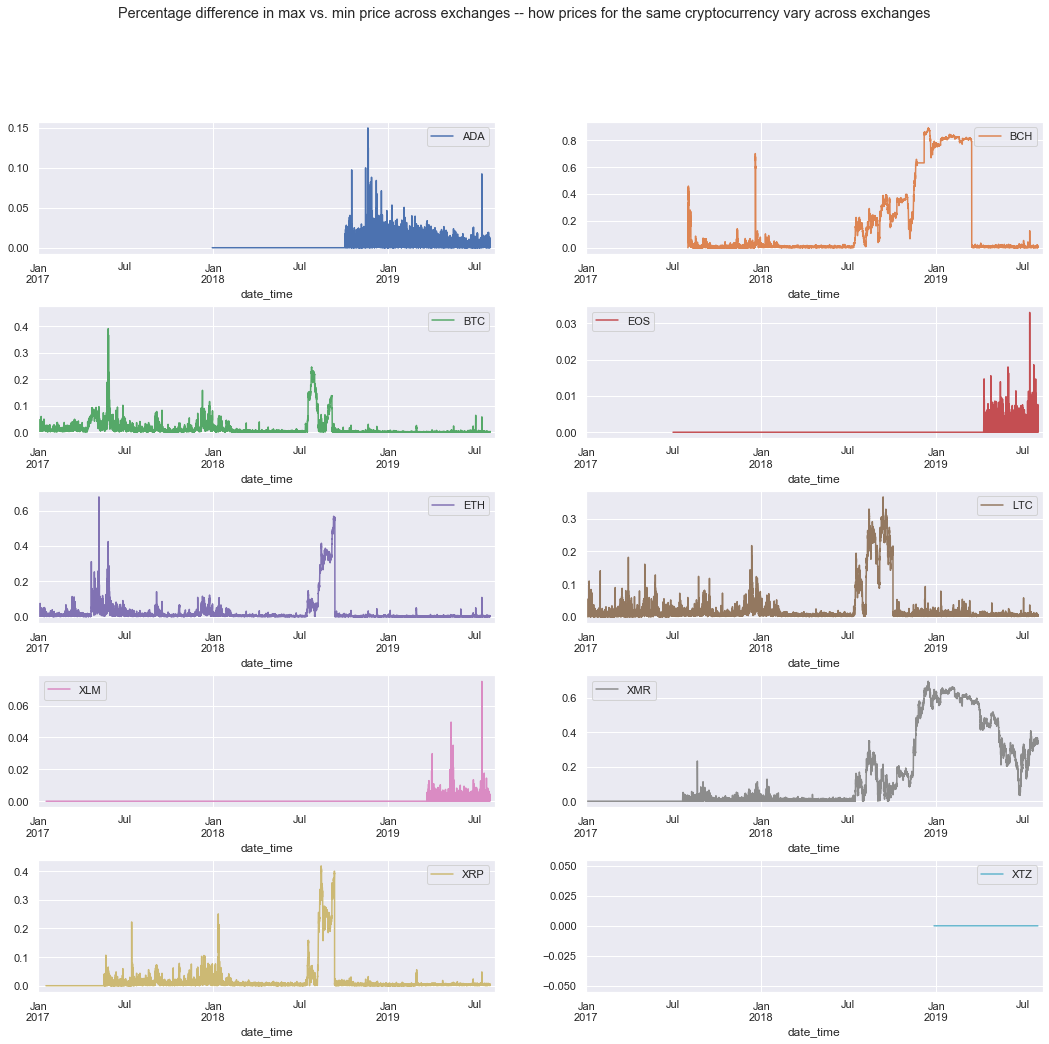

CPU times: user 9.38 s, sys: 478 ms, total: 9.86 s
Wall time: 10.4 s


In [6]:
%%time

# plot hourly range of close by coin;
# Note: we show the last ~2.5yrs of data since many exchanges don't have 
#       data for the earlier years of the sample
df_price_range = df[['date_time','Coin','close']].groupby(['date_time','Coin'])\
                                                 .agg(['min','max'])
df_price_range['range_perc'] = (df_price_range[('close', 'max')] - df_price_range[('close', 'min')]) / df_price_range[('close', 'max')]
df_price_range.reset_index()\
              .pivot(index='date_time', 
                     columns='Coin', 
                     values='range_perc')\
              .plot(subplots=True, 
                    layout=(5,2), 
                    figsize=(18,16), 
                    sharex=False,
                    title='Percentage difference in max vs. min price across exchanges -- how prices for the same cryptocurrency vary across exchanges',
                    xlim=('2017-01-01 00:00:00','2019-08-10 23:00:00'))
plt.subplots_adjust(hspace=0.4)
plt.show()

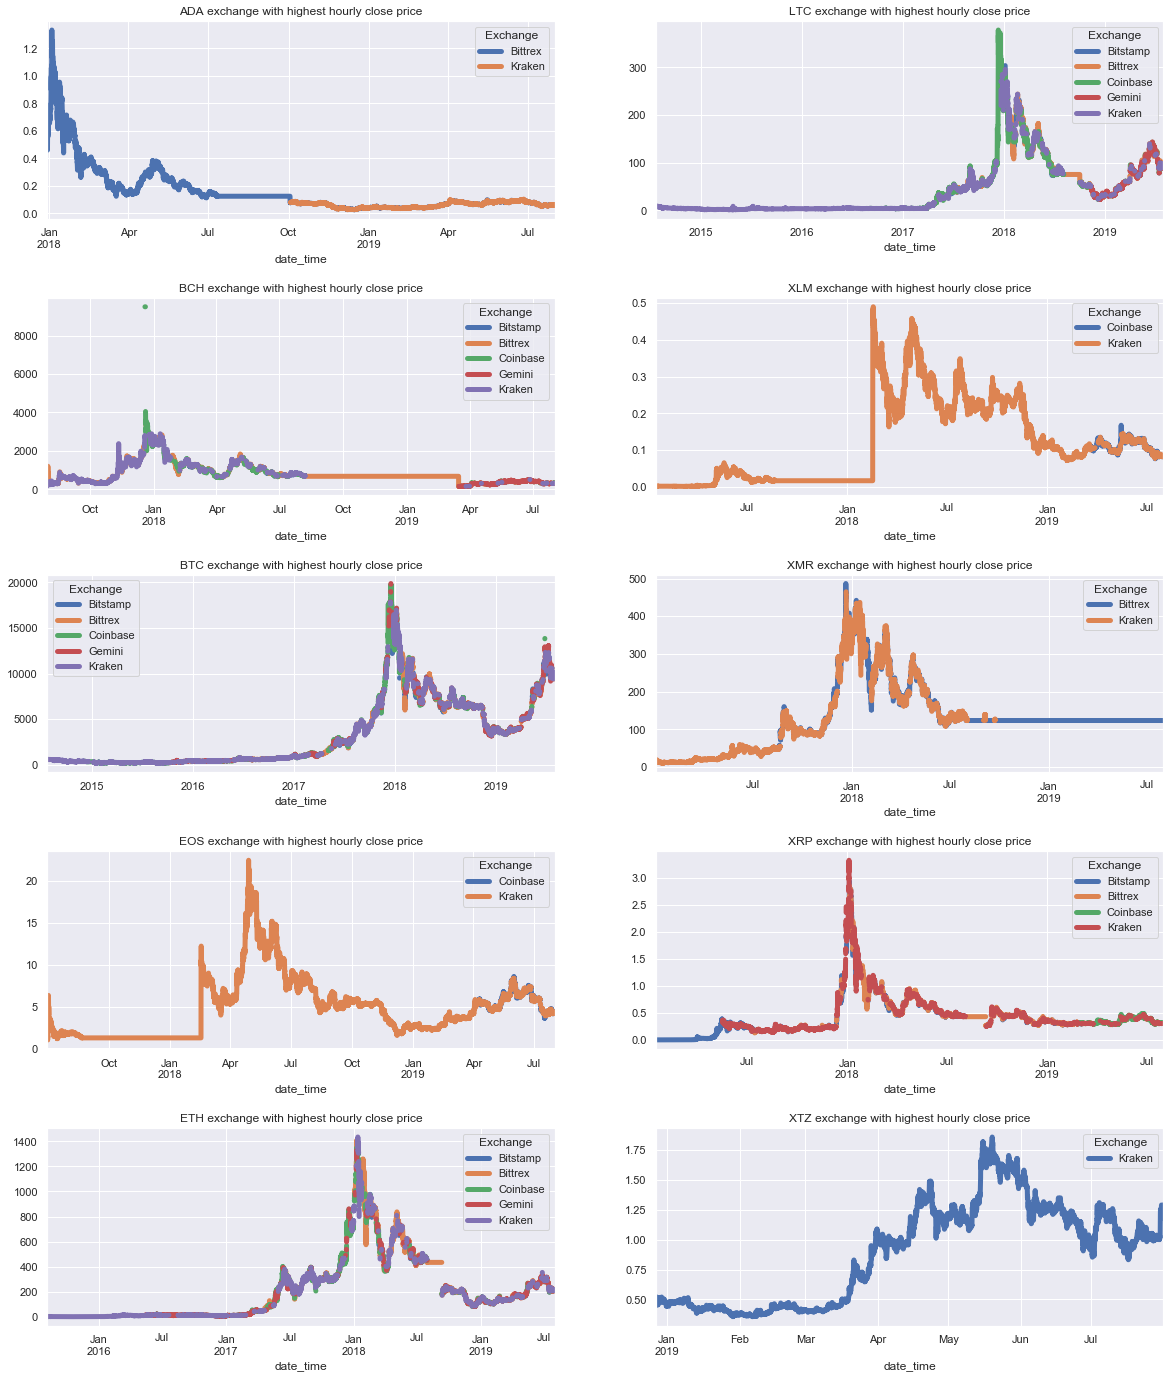

CPU times: user 13 s, sys: 824 ms, total: 13.8 s
Wall time: 18.2 s


In [7]:
%%time

df_max_close = df[['date_time','Coin','Exchange','close']].sort_values(['Coin','close'],
                                                                       ascending=[True,False])\
                                                          .groupby(['date_time', 'Coin'], 
                                                                   as_index=False)\
                                                          .first()
fig, axs = plt.subplots(5, 2, figsize=(20,24), sharex=False)
i = 0
j = 0

for c in df_max_close.Coin.unique():
    df_max_close[(df_max_close['Coin']==c) &
                 (df_max_close['close'].notna())].pivot(index='date_time',
                                                        columns='Exchange',
                                                        values='close')\
                                                 .plot(linewidth=5,
                                                       title='{} exchange with highest hourly close price'.format(c),
                                                       ax=axs[i,j])
    i = i + 1 if i < 4 else 0
    if i == 0: j = 1

plt.subplots_adjust(hspace=0.4)
plt.show()

#### 3. What exchanges (venues) report the most activity in Bitcoin (BTC)? Ethereum (ETH)?

In examine "activity" of BTC and ETH, we look at volumes in aggregate as well as across time. Aggregating across the entire sample, Coinbase had the highest level of activity for both BTC and ETH in terms of cumulative volume, average hourly volume, average daily volume, and total annual volume by year (for most recent years). Bitstamp had the second highest volume for BTC, while Gemini (2017) and Kraken (2018-19) had the second highest volume for ETH.

To look into potential seasonal or weekly patterns, we also aggregate by month and day of the week. Coinbase, followed by Bitstamp, had the most volume of BTC across months; however, an interesting seasonal pattern emerges. It appears that volume is highest in summer and winter, and lowest in spring and fall, creating an oscillating pattern of volume. ETH exhibits a similar seasonal pattern in volume and also has Coinbase as the exchange of most volume. Kraken is the exchange with the second highest amount of volume of ETH except for Jan, Aug, and Dec, when Gemini had the second highest amount of volume of ETH. 

Volume of BTC and ETH by day of week also exhibits an interesting pattern: from Monday, volume increases into the middle of the week, then decreases into the weekend, with the two weekend days having the least volume.

Across time, we note a spike in volume across exchanges during 2018 and at the end of the sample for both BTC and ETH, as well as a mid-2017 spike in ETH volume. Combined with the previous observation that prices spiked in 2018, there may be an underlying event that occurred during this time frame that caused this pattern across the market (ICO boom).

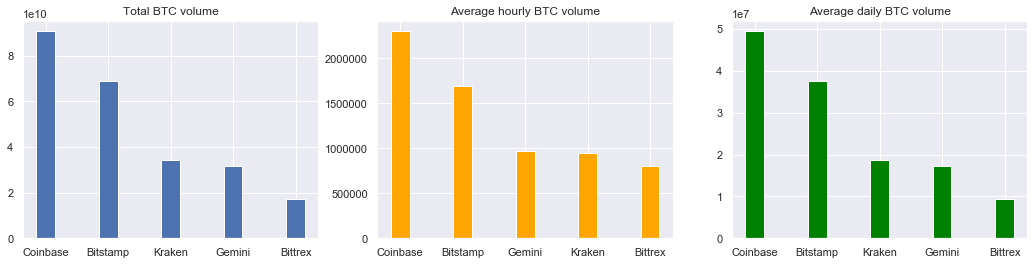

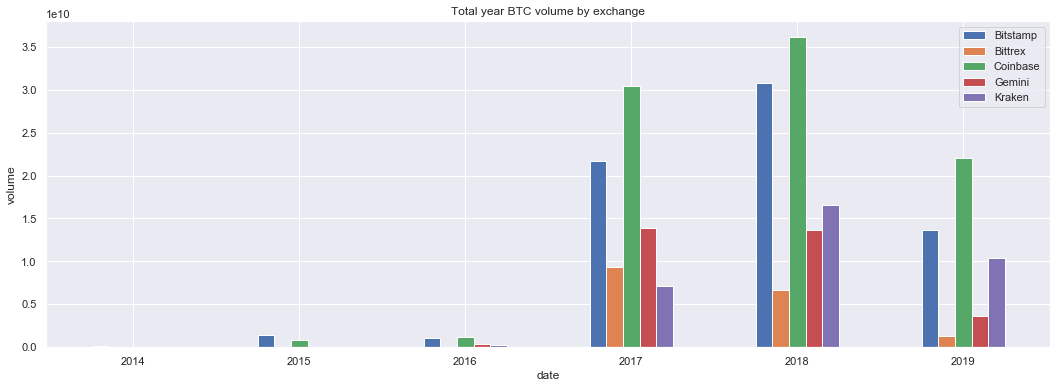

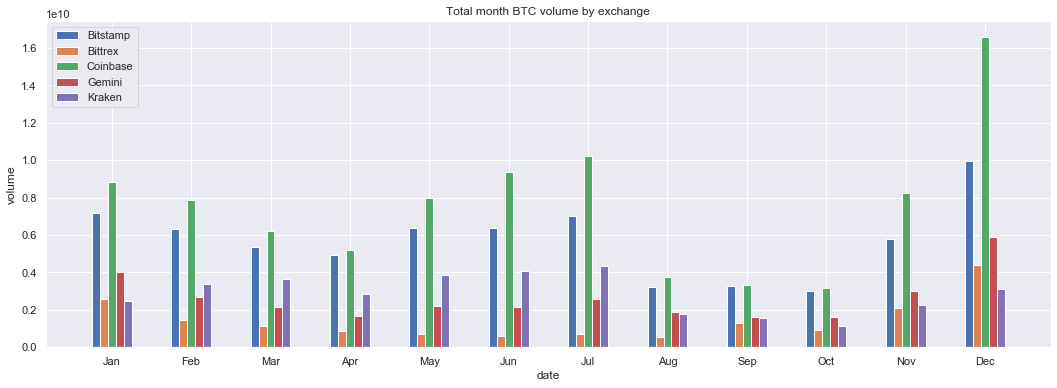

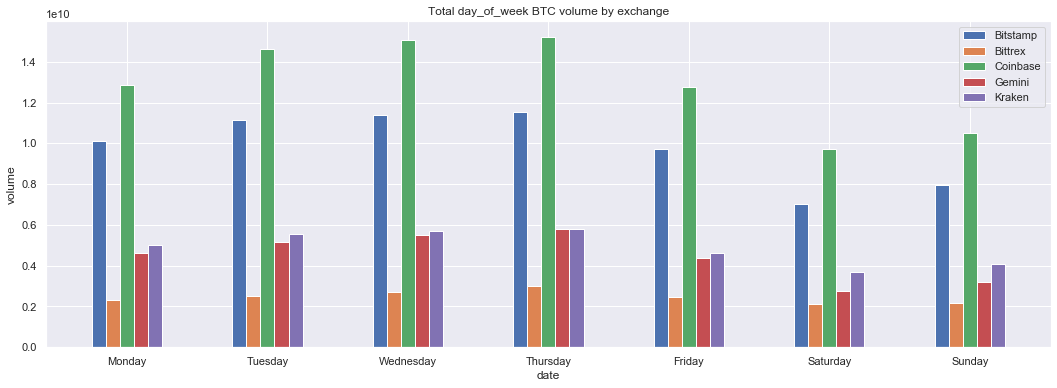

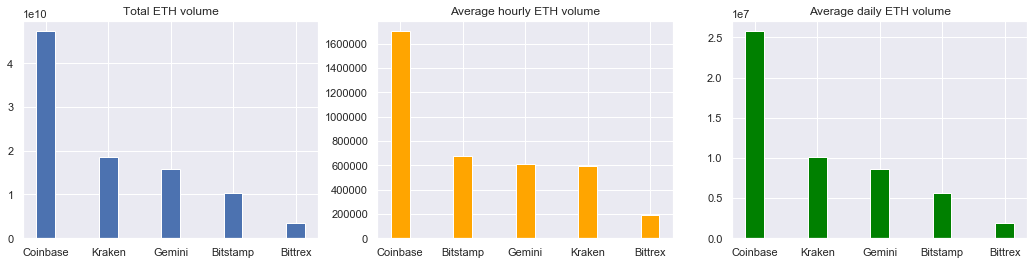

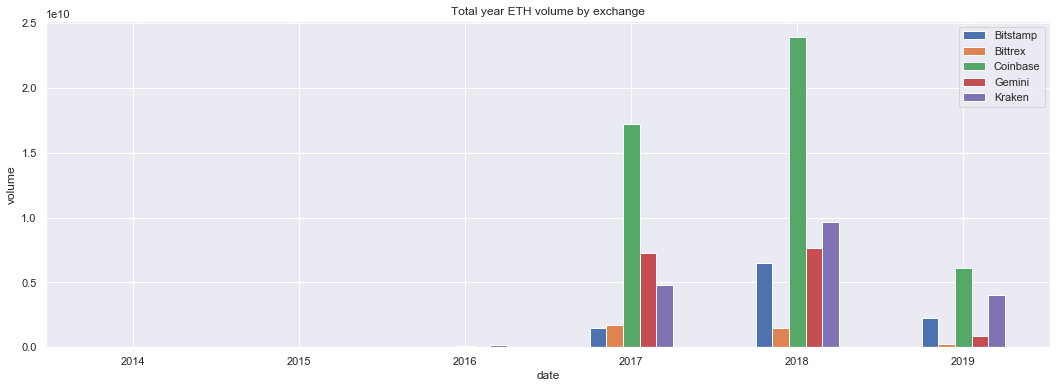

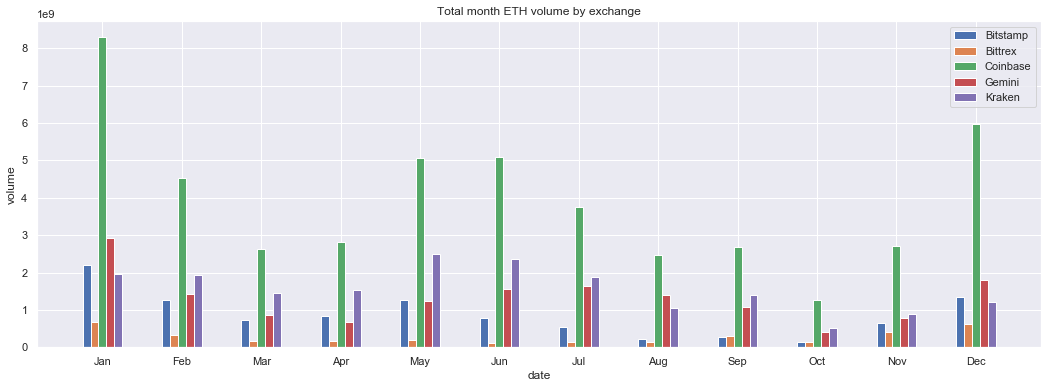

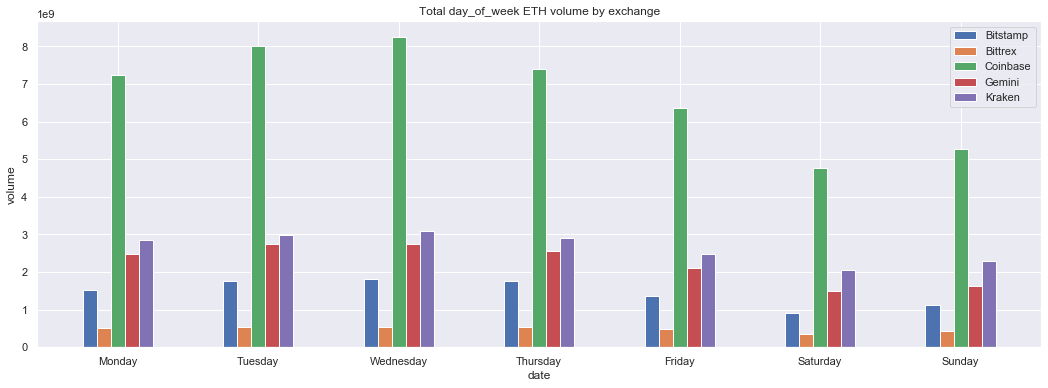

CPU times: user 6.89 s, sys: 507 ms, total: 7.4 s
Wall time: 8.69 s


In [8]:
%%time

plot_overall_volume_by_exchange(df, 'BTC')
plot_overall_volume_by_exchange(df, 'ETH')

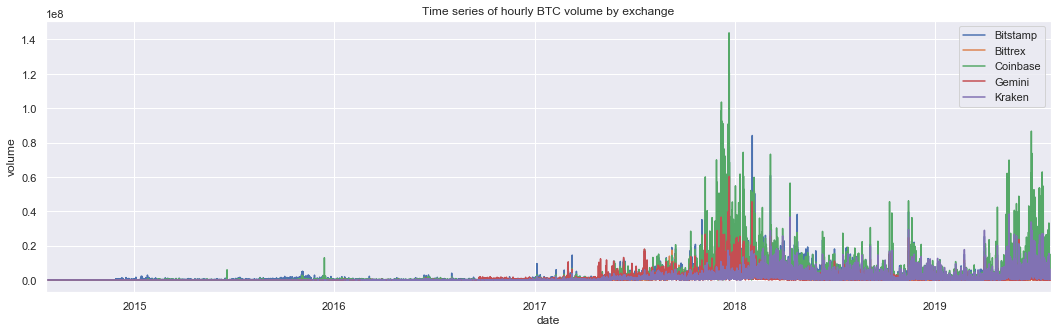

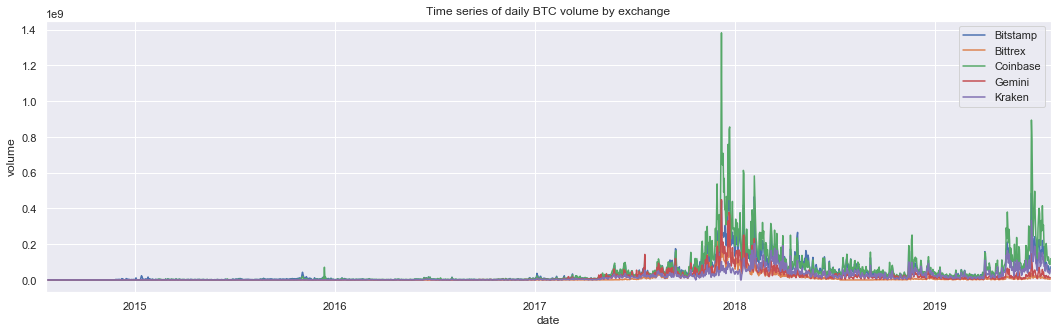

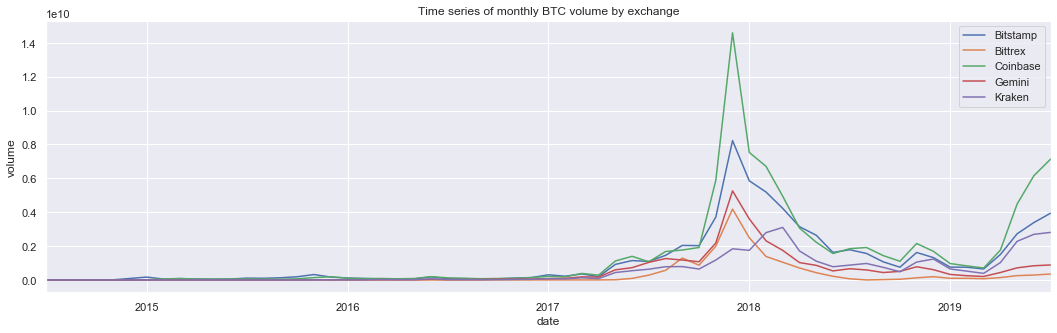

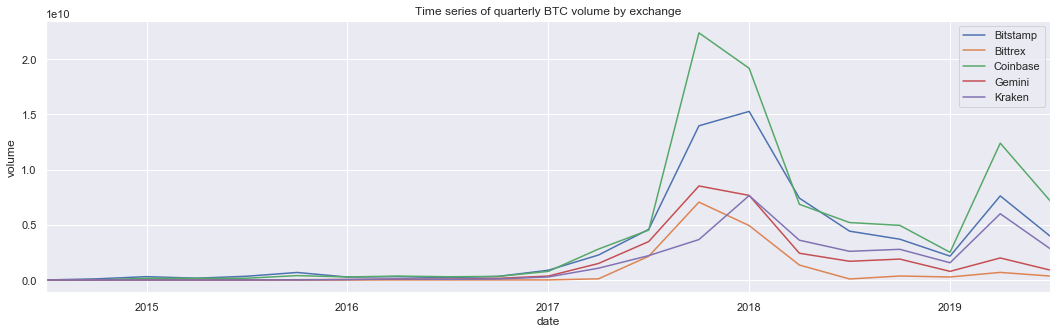

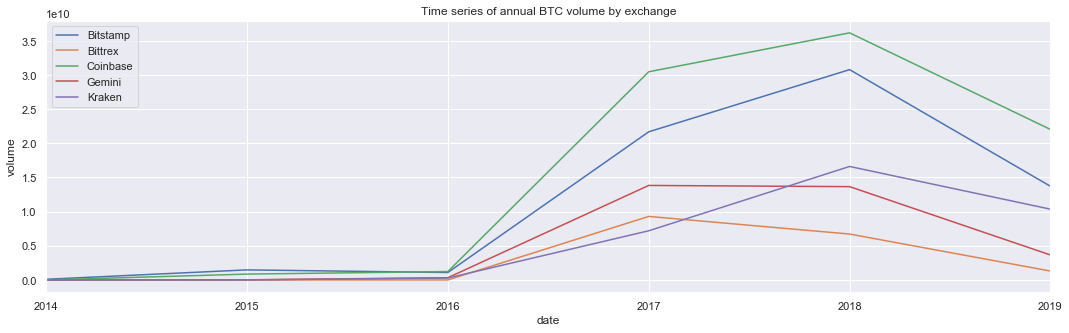

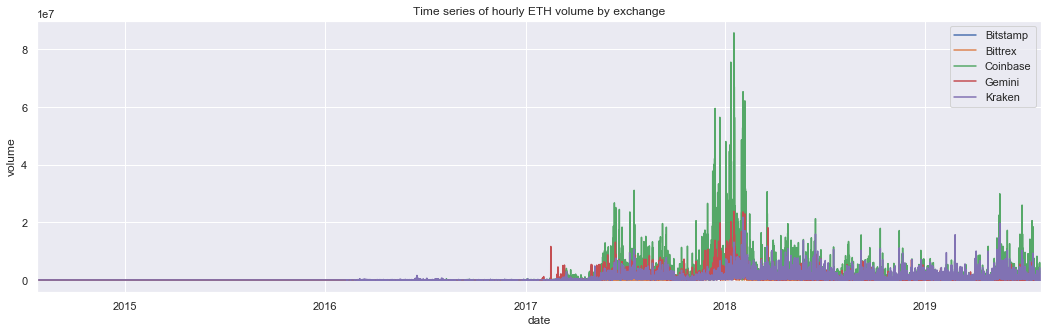

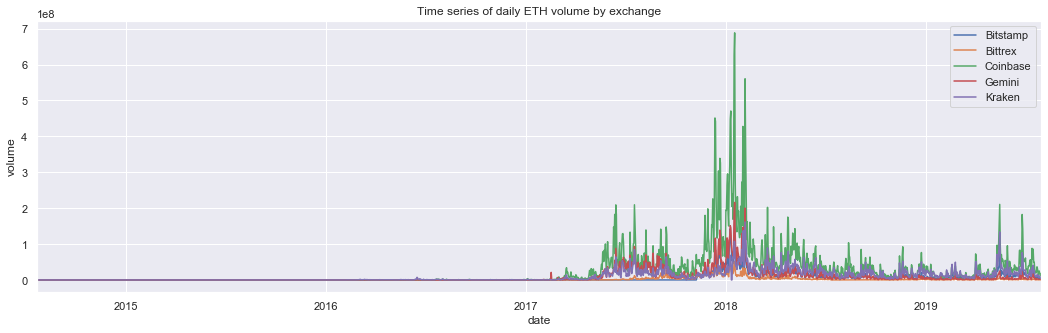

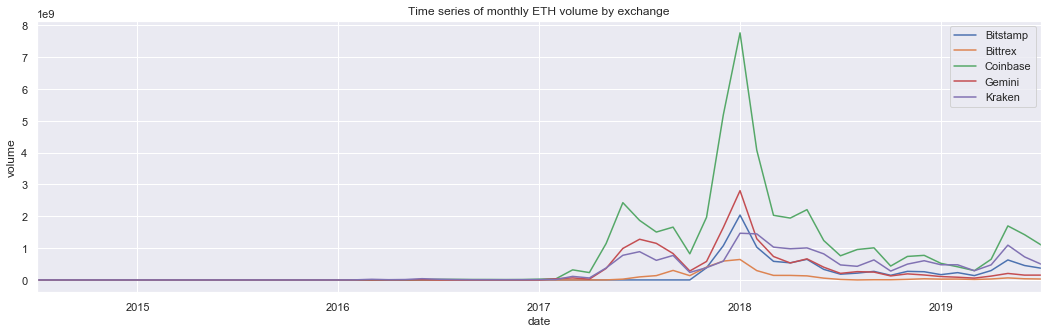

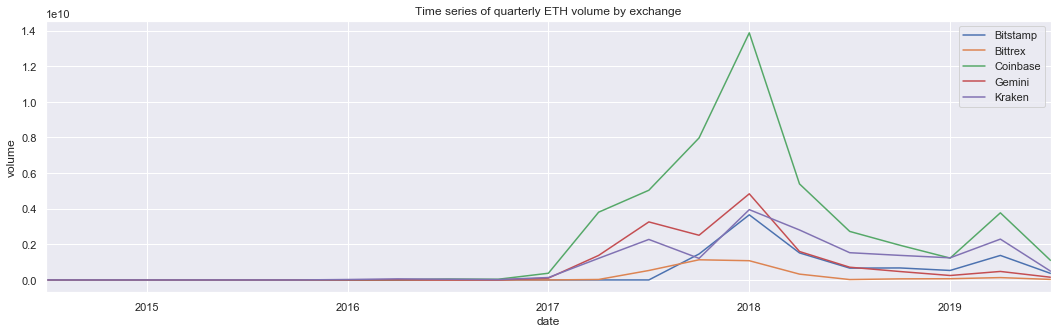

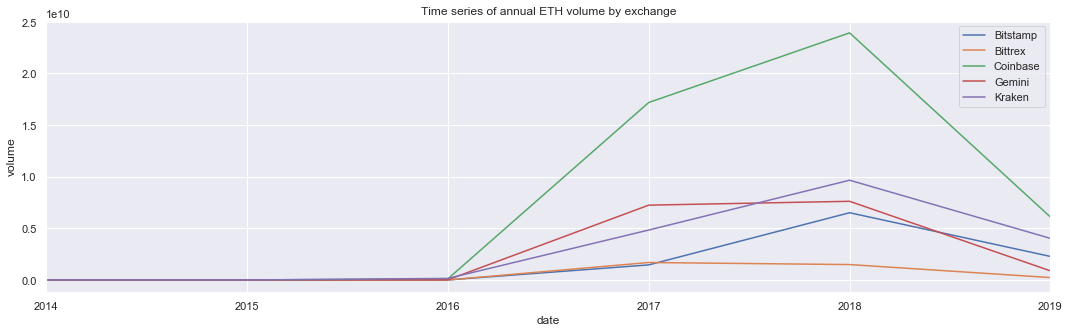

CPU times: user 9.69 s, sys: 784 ms, total: 10.5 s
Wall time: 10.9 s


In [9]:
%%time

wrapper_plot_volumes(df, 'BTC')
wrapper_plot_volumes(df, 'ETH')

#### 4. Compute 5-minute log returns. For equity return data, one must typically adjust for dividends or corporate actions. Is this necessary for crypto?

Adjustments for dividends or corporate actions are not necessary for crypto, but forks, which resemble (split/dividend) in that price (decreases/increases) following the fork, are considered. Specifically, we look at the BTC/BCH fork of 2017-08-01 as well as the ETC/ETH fork of 20 July 2016. 

For the case of the BTC/BCH fork, we see that the price of BTC fell; thus, the fork acted similar to a stock split. Log returns also appeared to drop when the fork occurred. 

Unlike Bitcoin, the ETC/ETH fork appears to have caused a rise in the price and log returns of ETH; thus resembling a stock dividend.

These opposite post-fork reactions may be due to the fact that the BTC/BCH fork resulted in a doubling of coins--those who held BTC received an amount of BCH equal to their amount of BTC--whereas the Ethereum fork resulted in fewer coins due to an attack.

In [10]:
%%time

# NOTE: since the frequency of the available data is hourly, 
#       we compute hourly log returns, rather than 5-min log returns

df_returns = df.sort_values(['Coin','Exchange','date_time'])[['date_time', 'Coin', 'Exchange', 'close']]
df_returns['close_lag1'] = df_returns[['close']].shift(1)
df_returns['close_lag1'] = np.where(df_returns['date_time']==df_returns['date_time'].min(),
                                    np.nan,
                                    df_returns['close_lag1'])
df_returns['log_returns'] = np.log(df_returns['close'] / df_returns['close_lag1']) * 100

CPU times: user 1.35 s, sys: 374 ms, total: 1.73 s
Wall time: 1.35 s


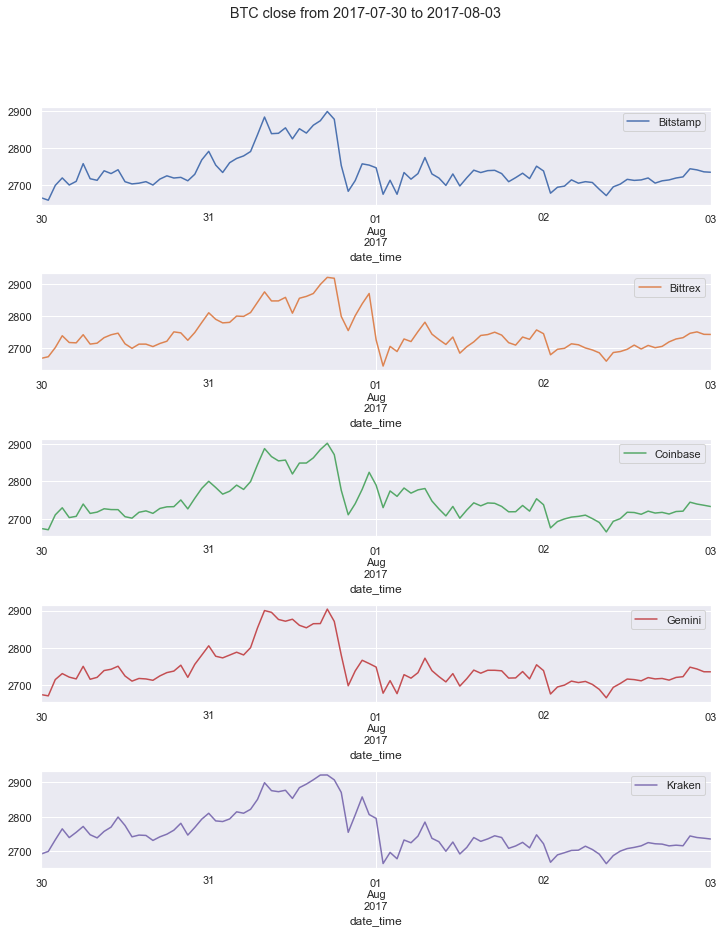

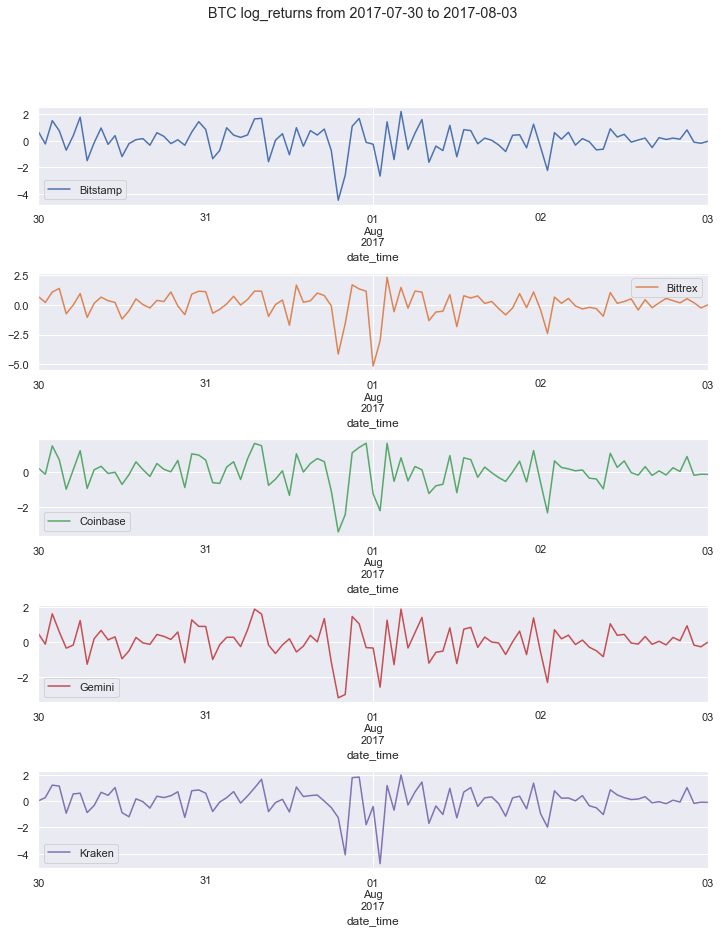

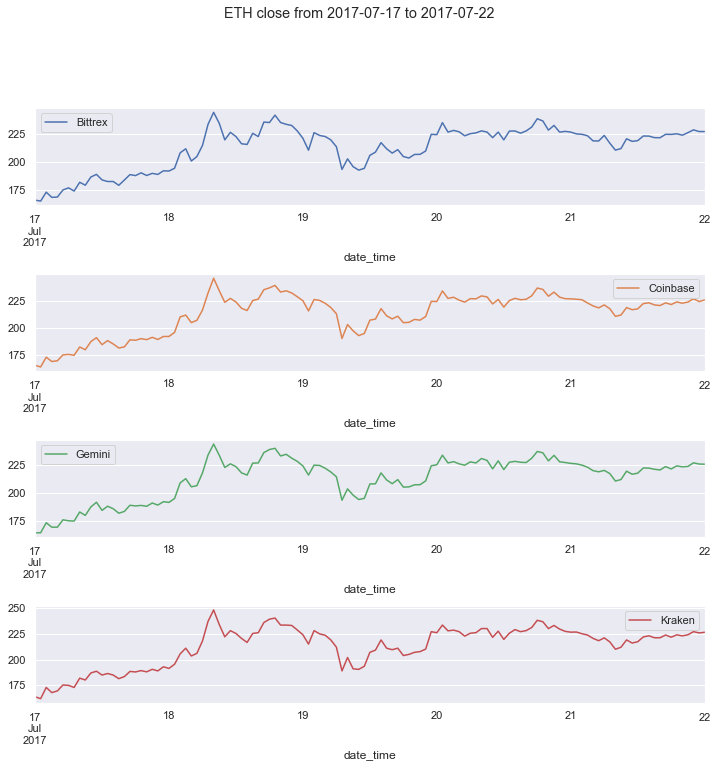

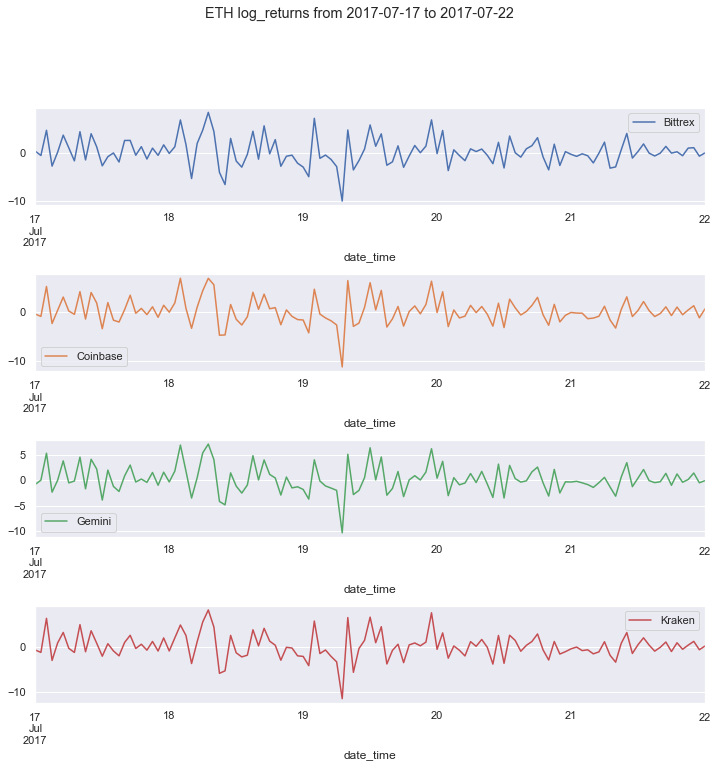

CPU times: user 4.97 s, sys: 259 ms, total: 5.23 s
Wall time: 5.22 s


In [11]:
%%time

# exclude Bitstamp exchange for ETH (no volume)
wrapper_plot_split(df_returns, 'BTC', '2017-07-30', '2017-08-03')
wrapper_plot_split(df_returns[df_returns['Exchange']!='Bitstamp'], 'ETH', '2017-07-17', '2017-07-22')

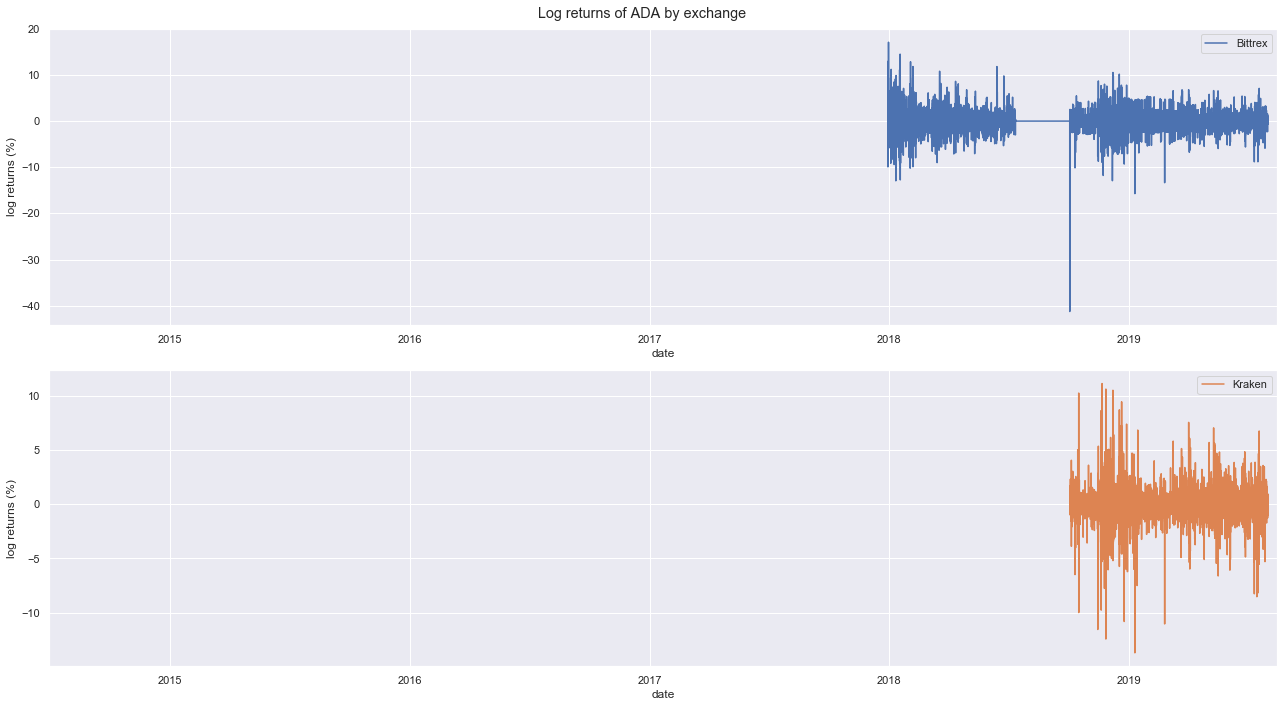

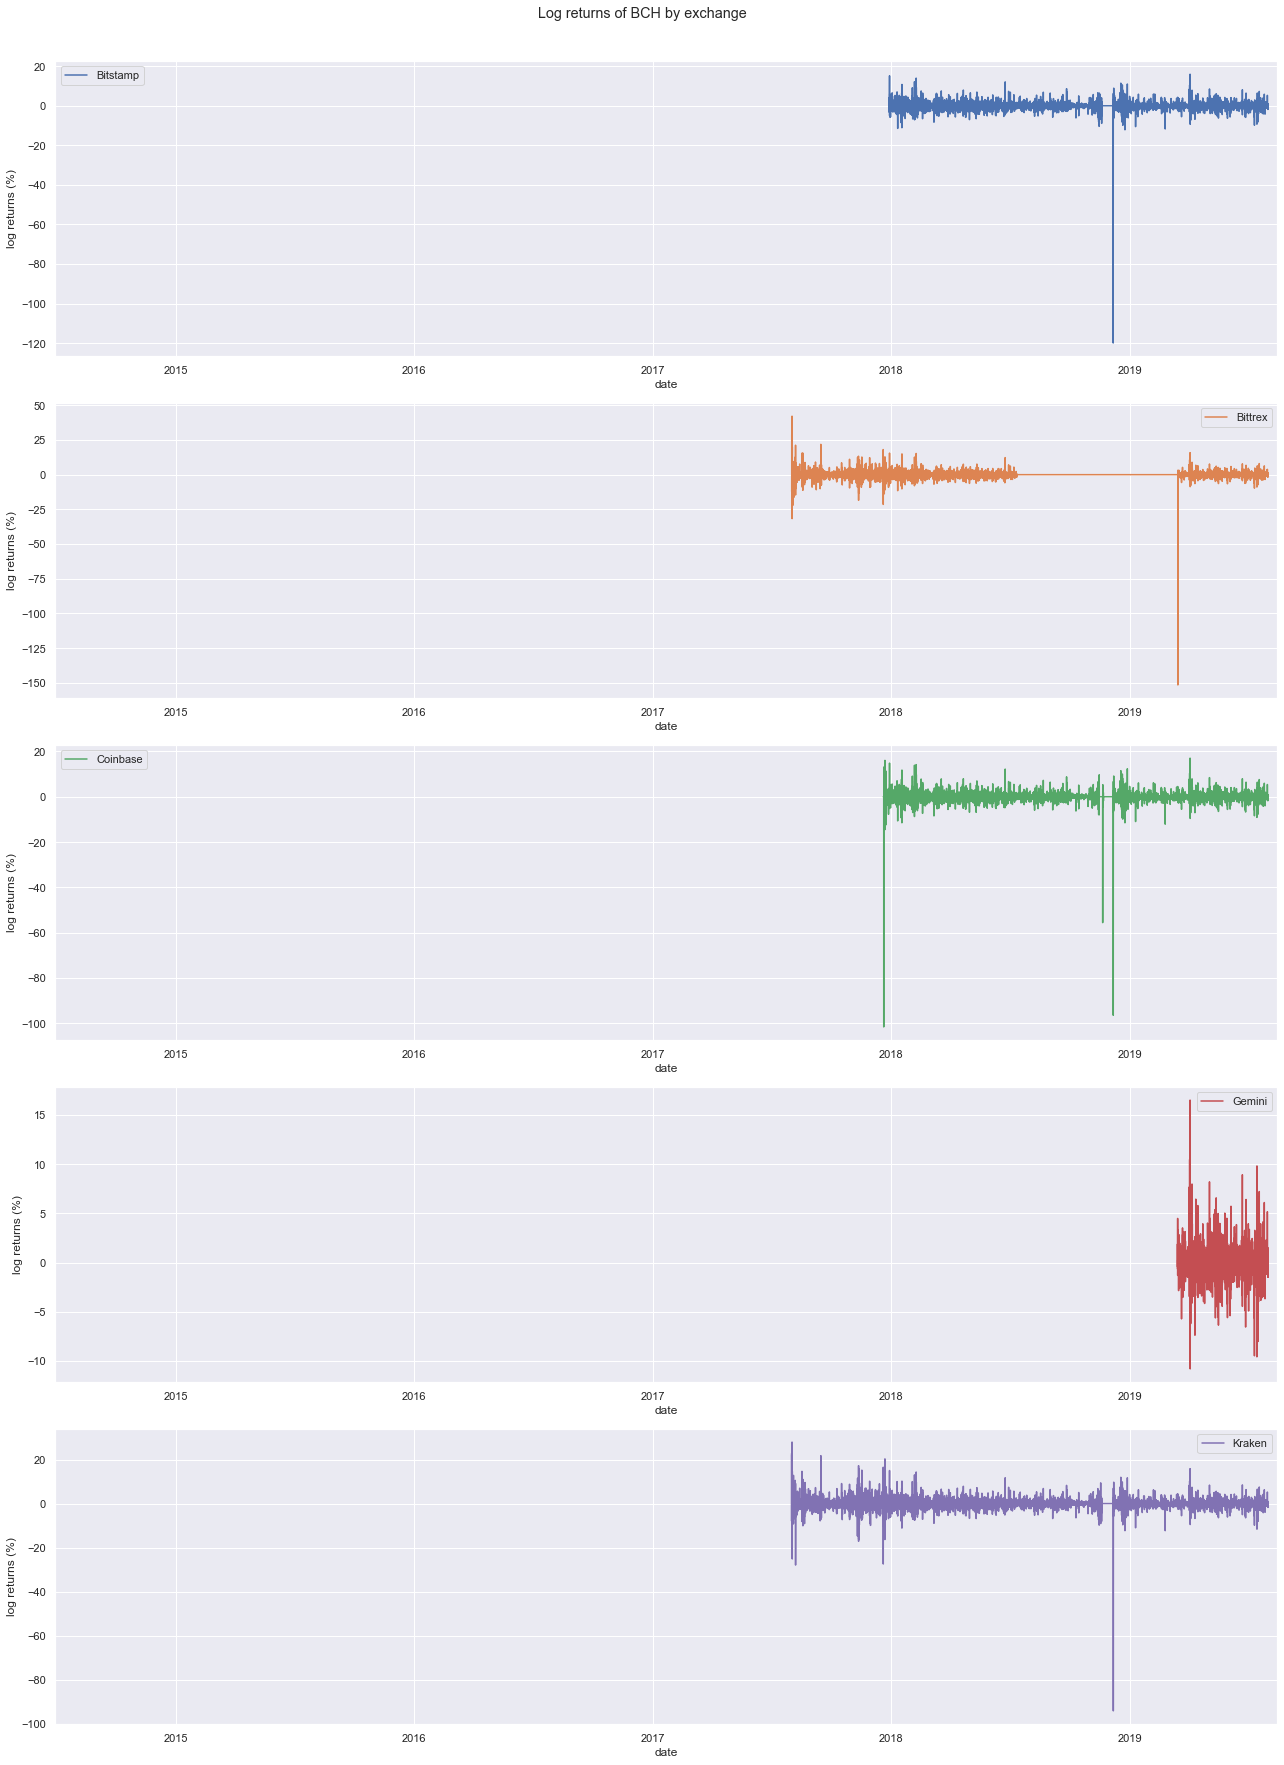

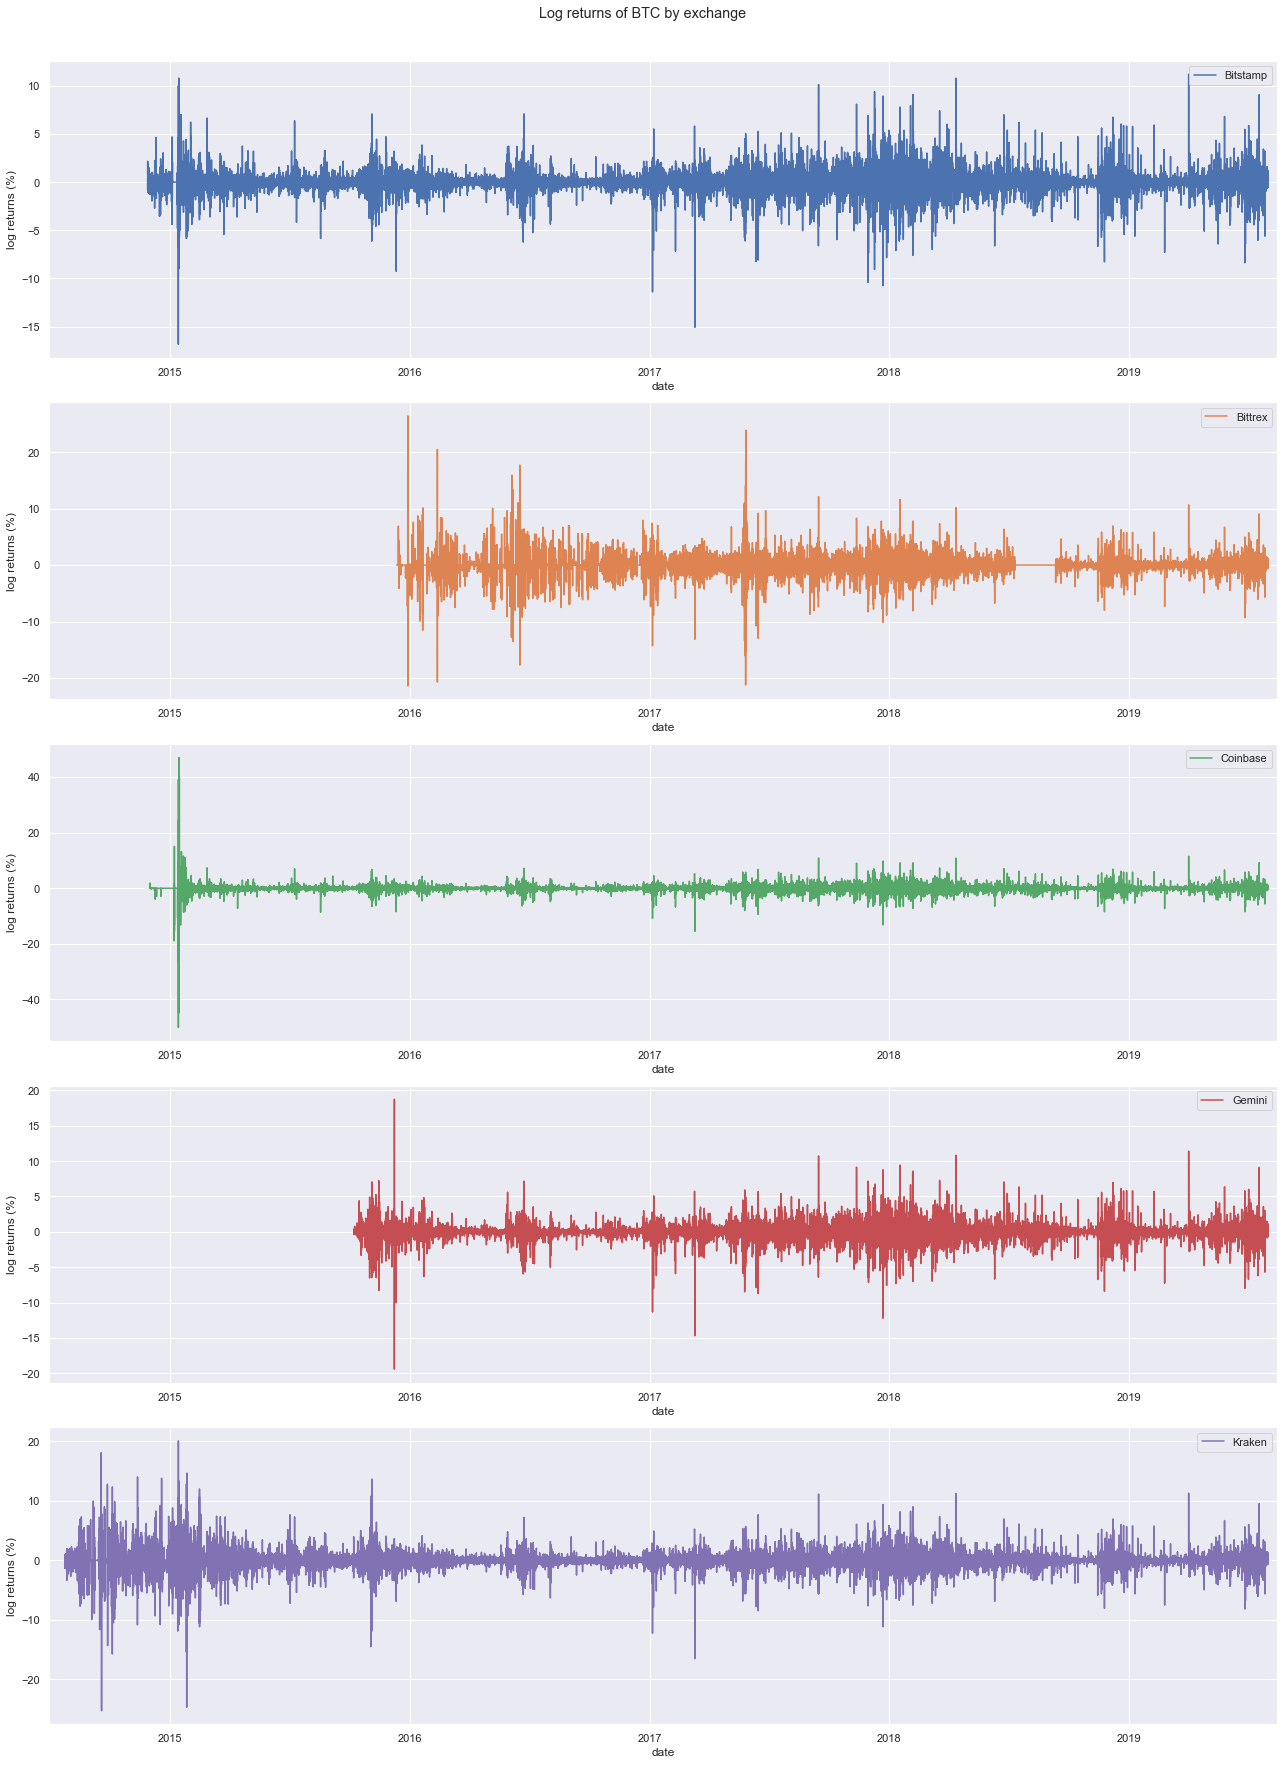

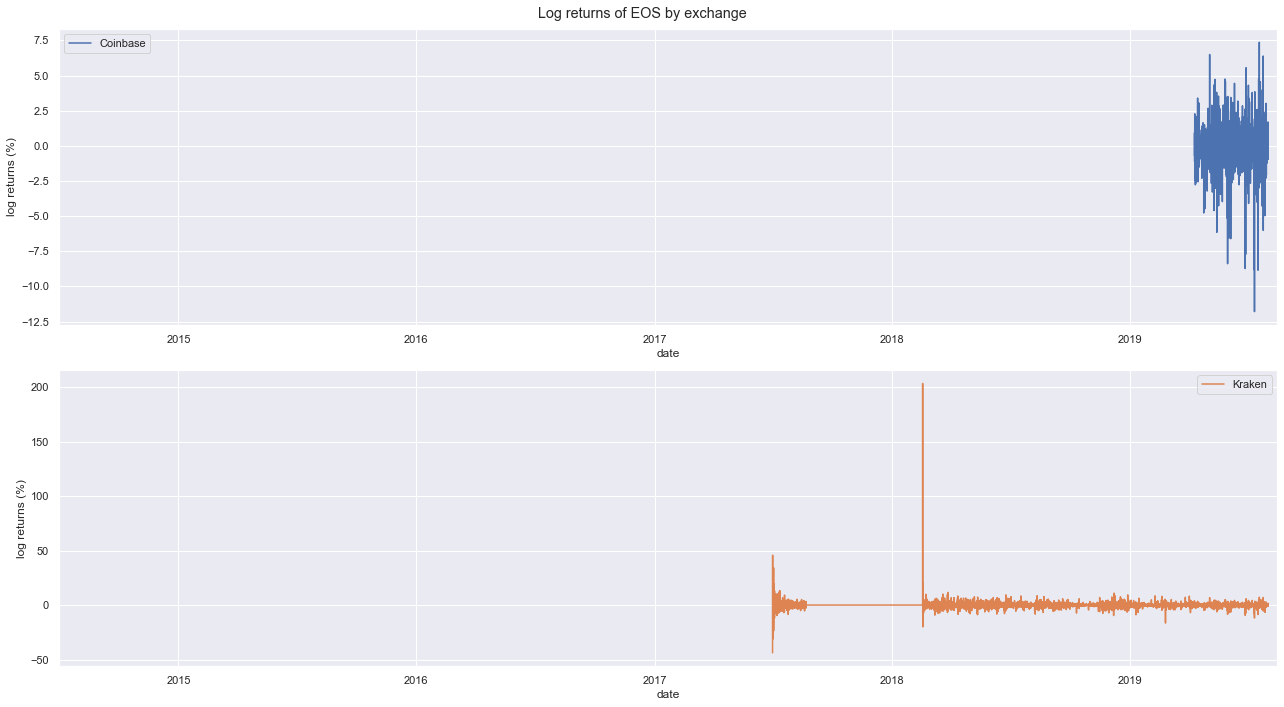

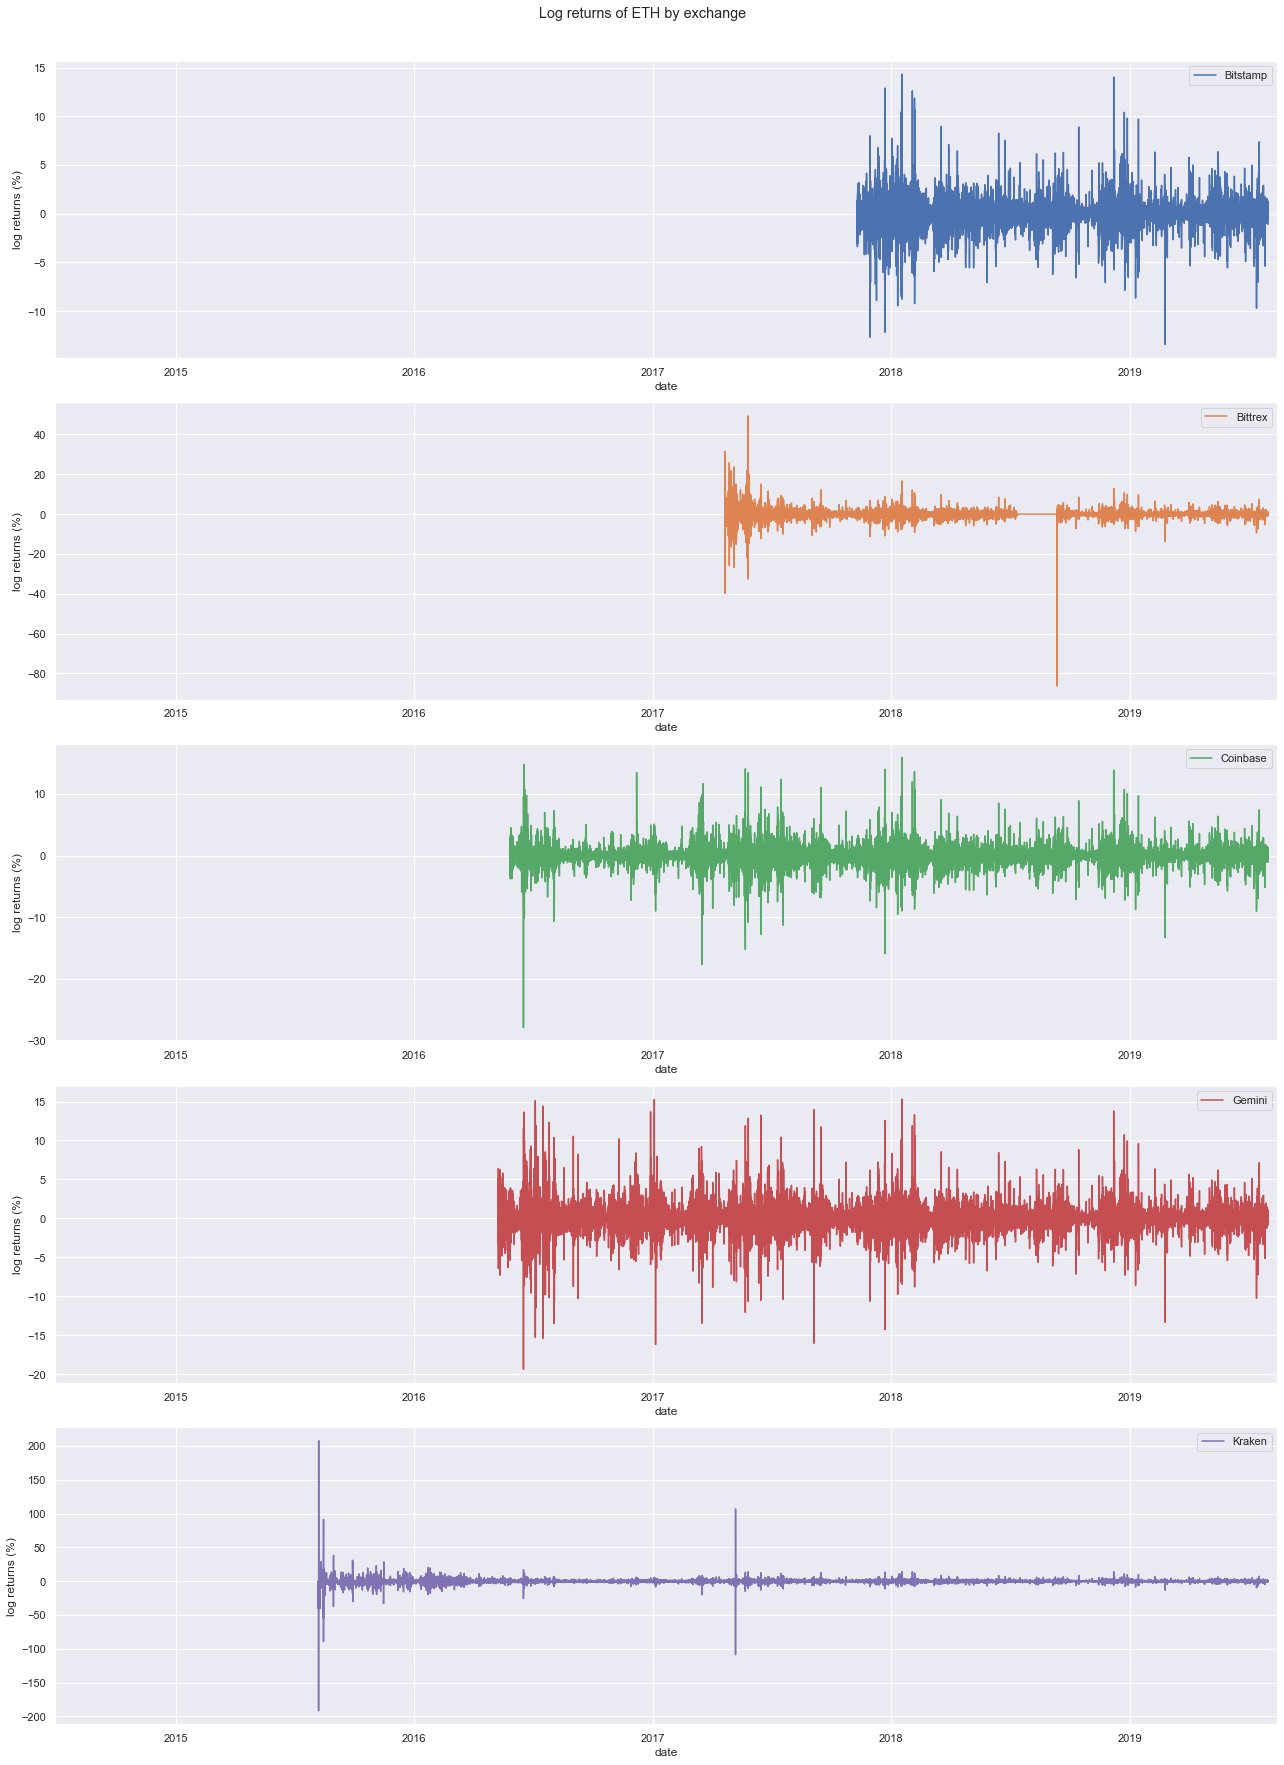

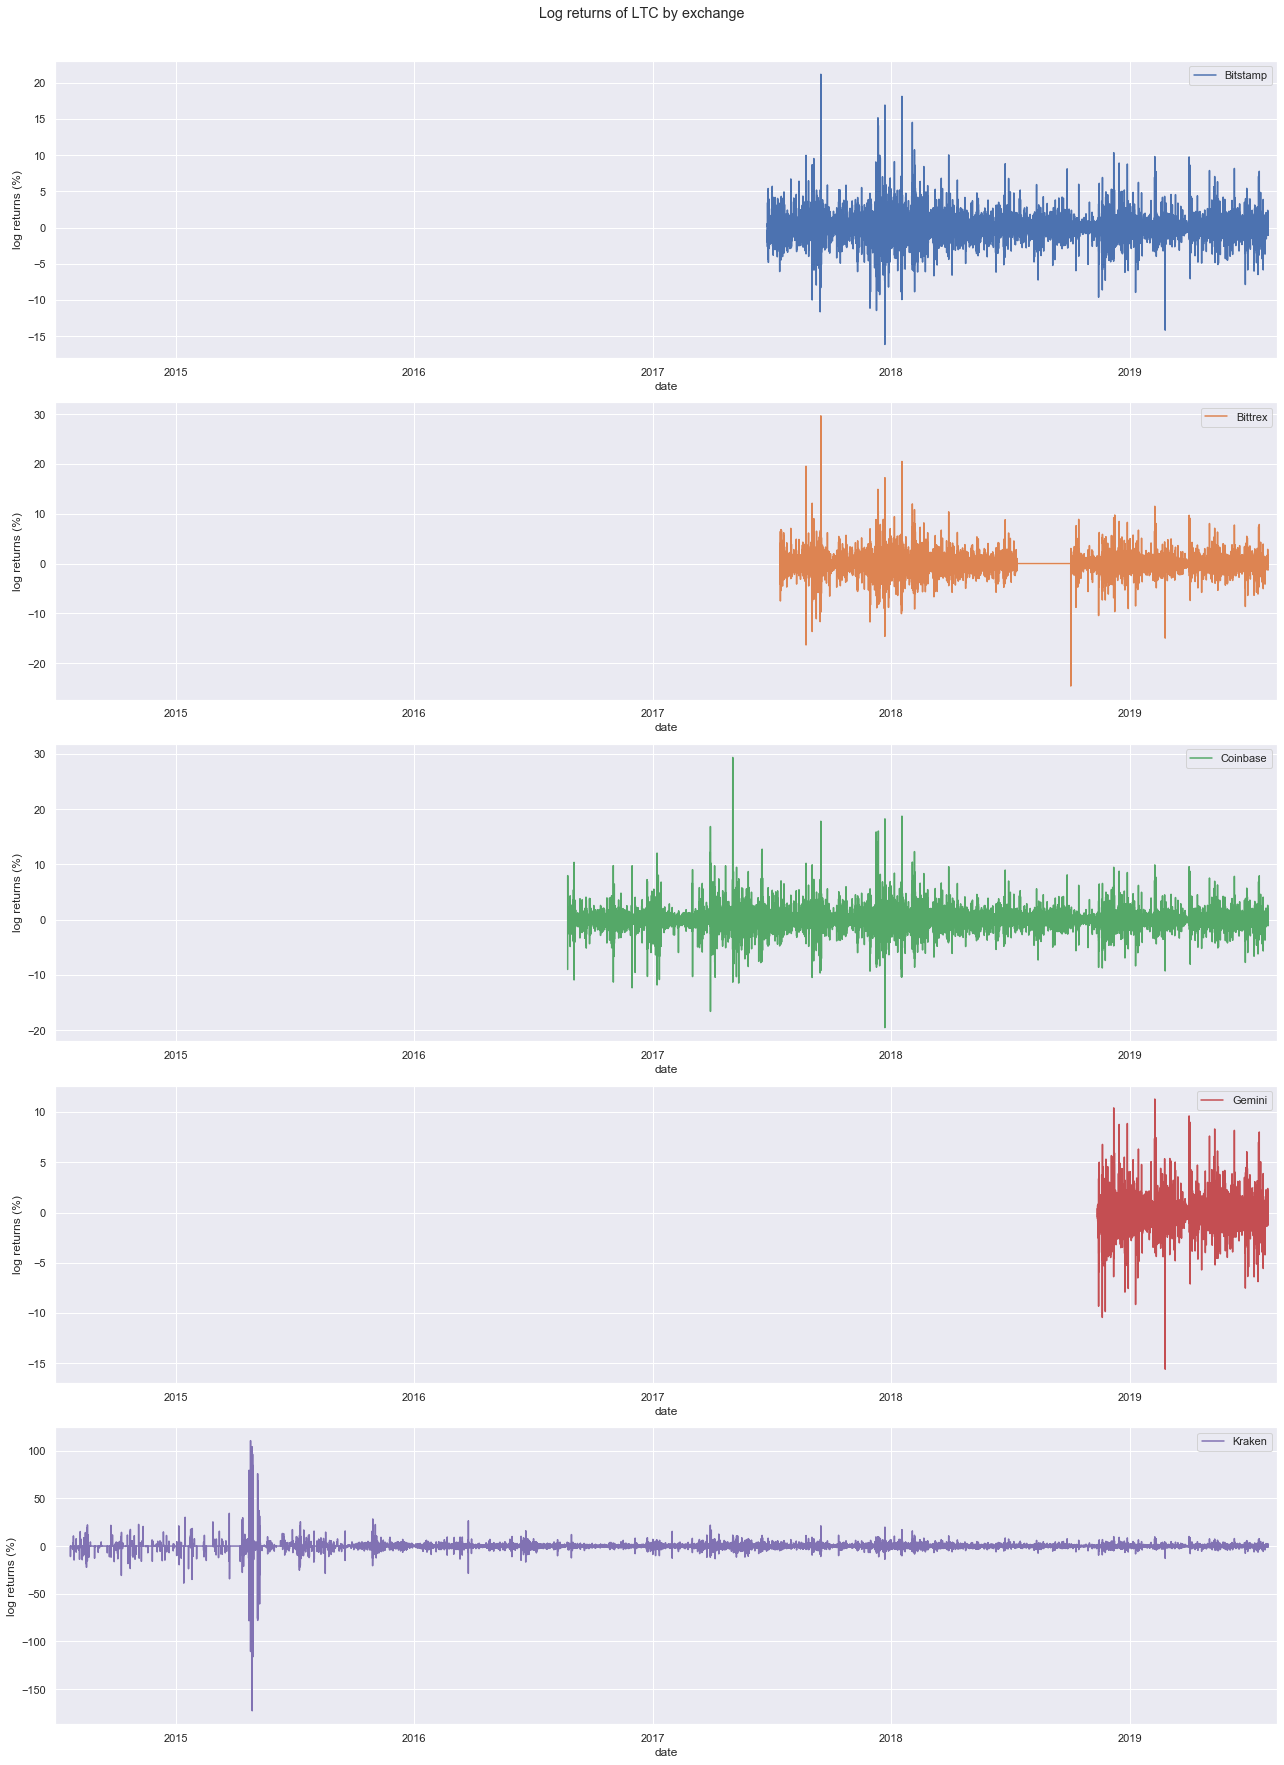

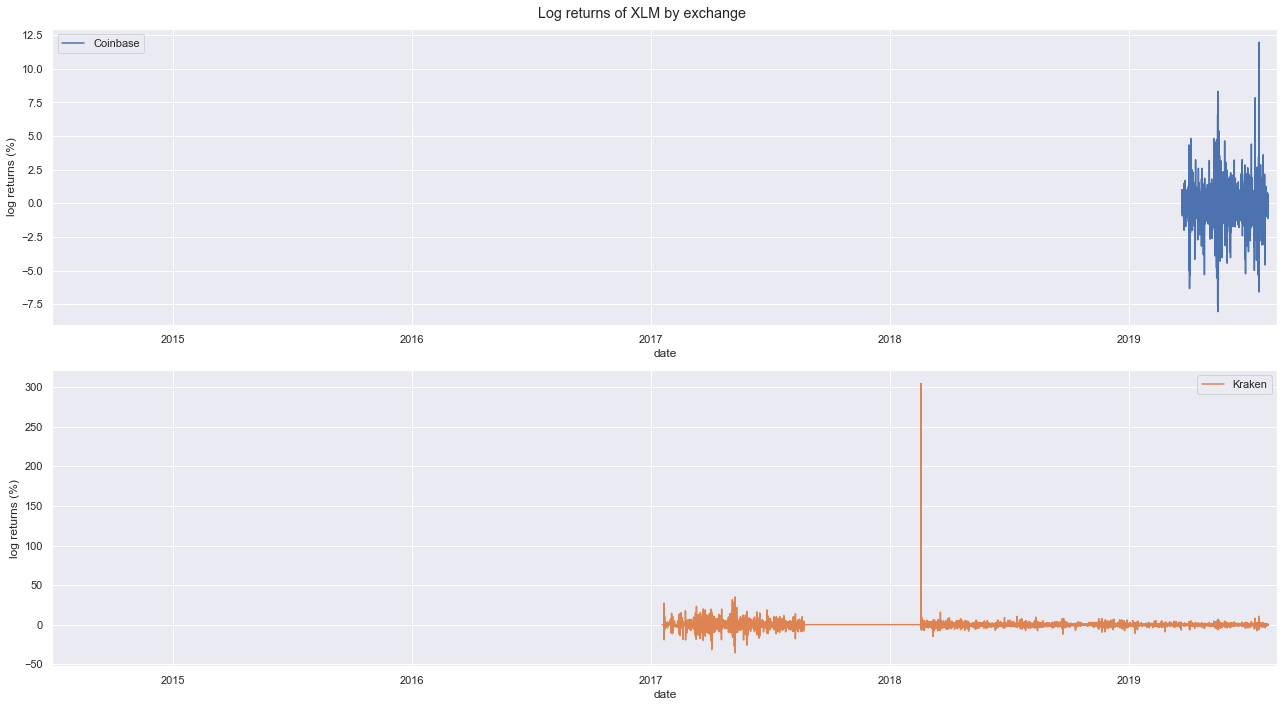

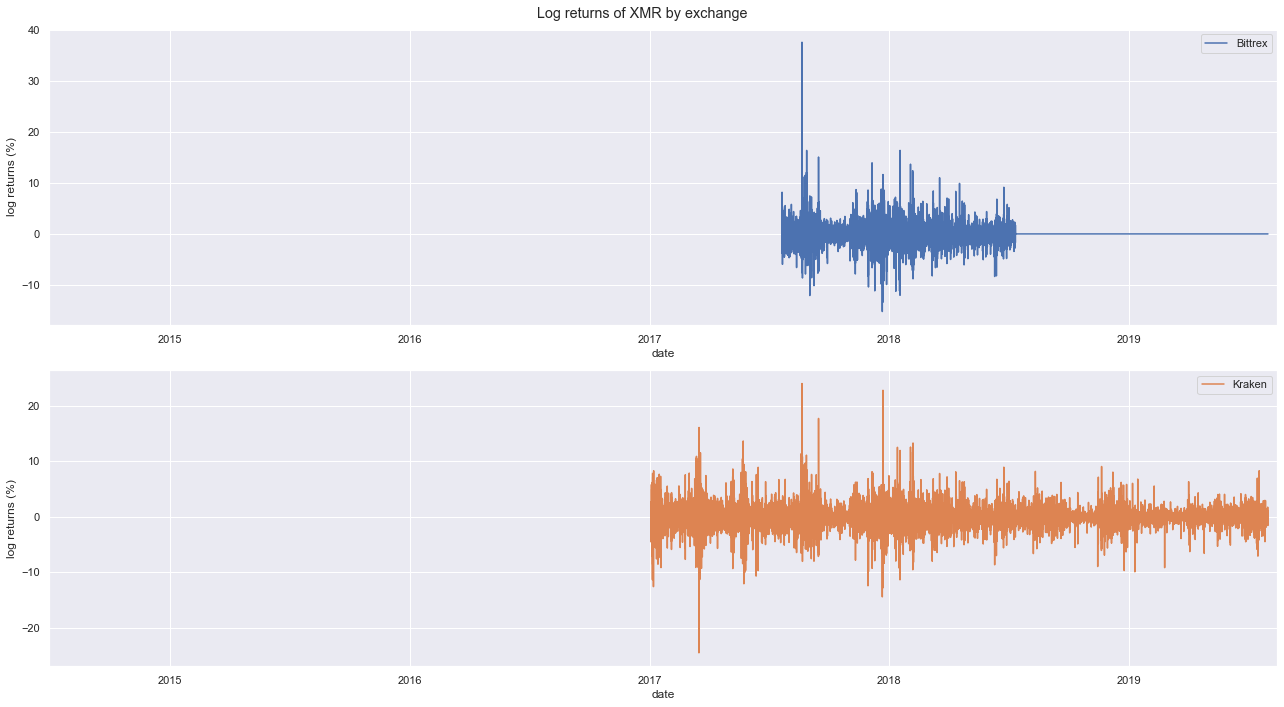

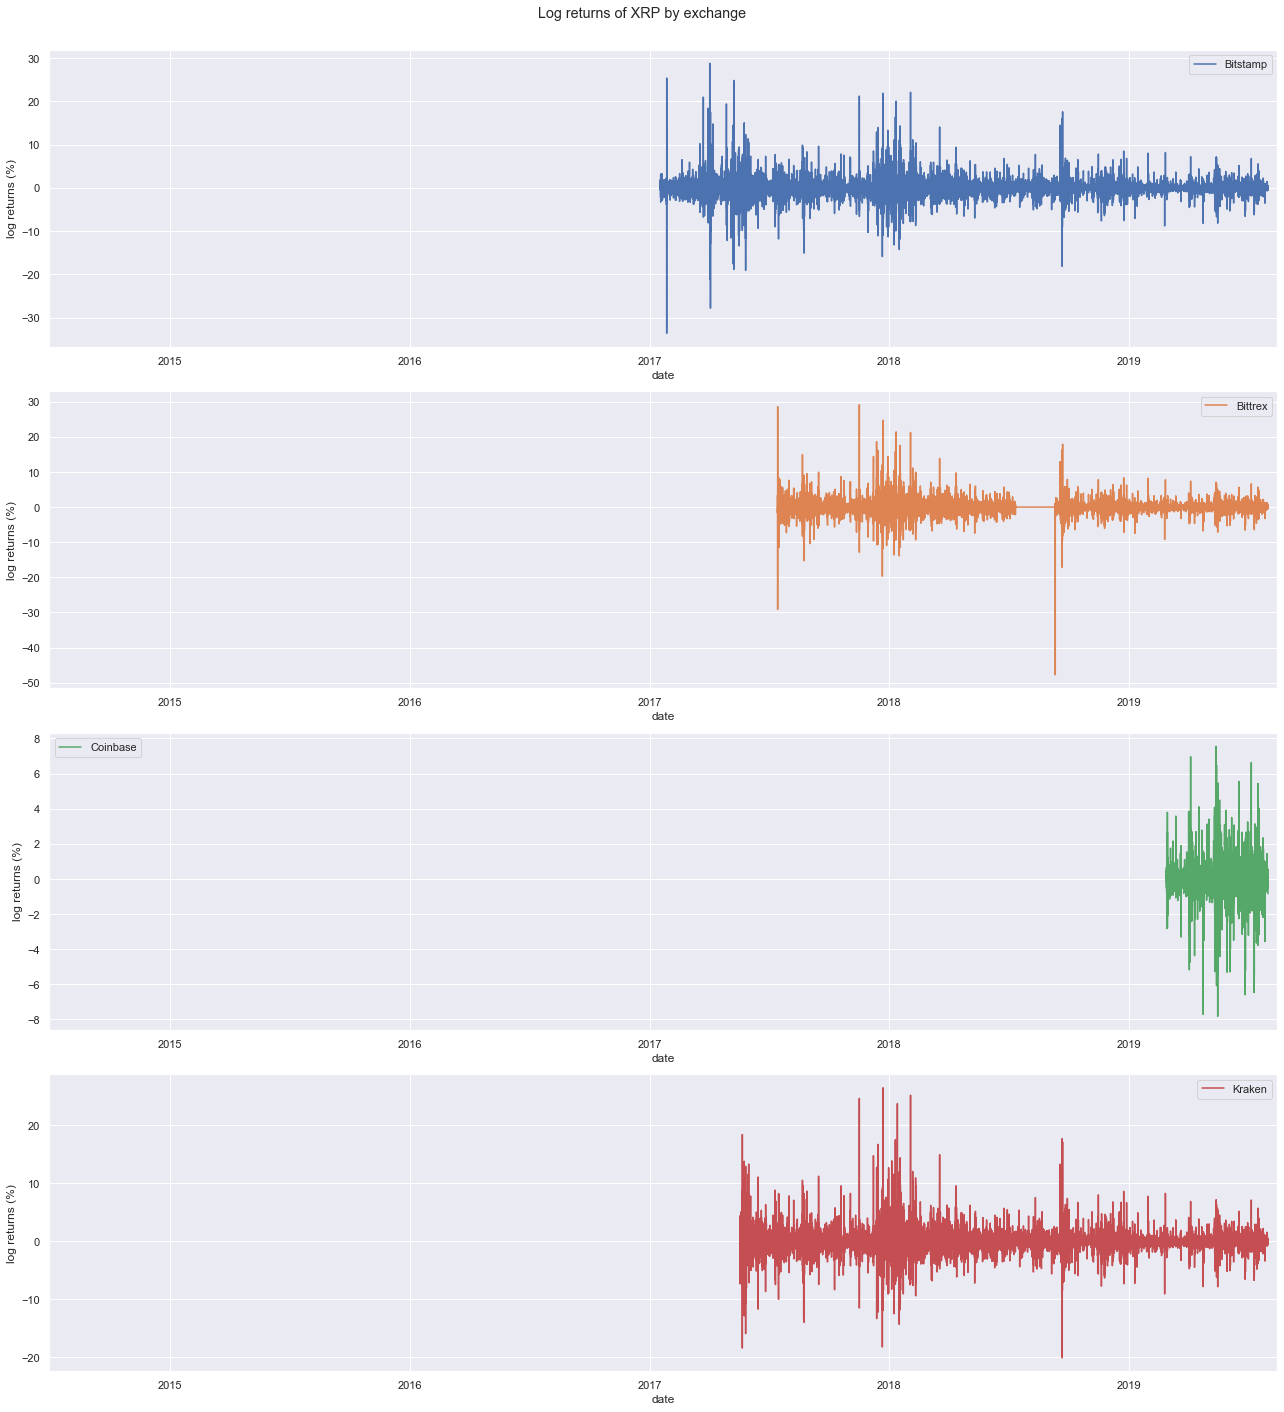

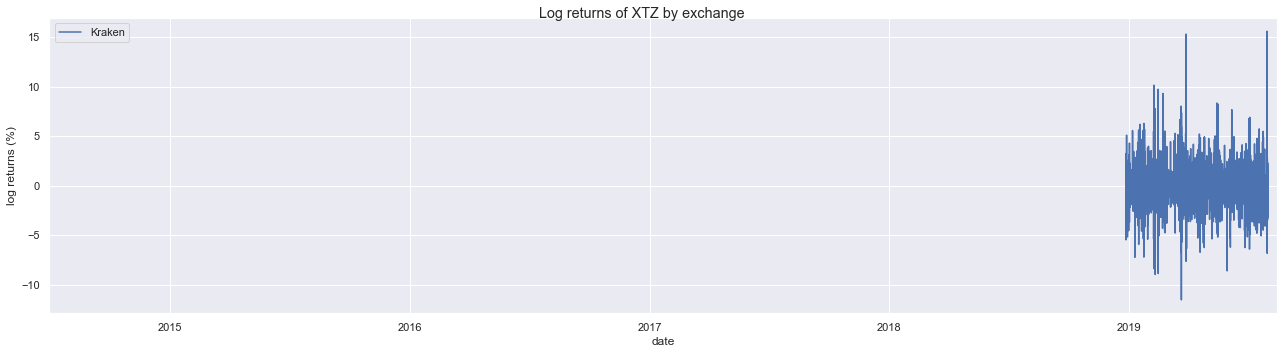

CPU times: user 26.9 s, sys: 832 ms, total: 27.7 s
Wall time: 29 s


In [12]:
%%time

plot_log_returns_by_coin(df_returns)

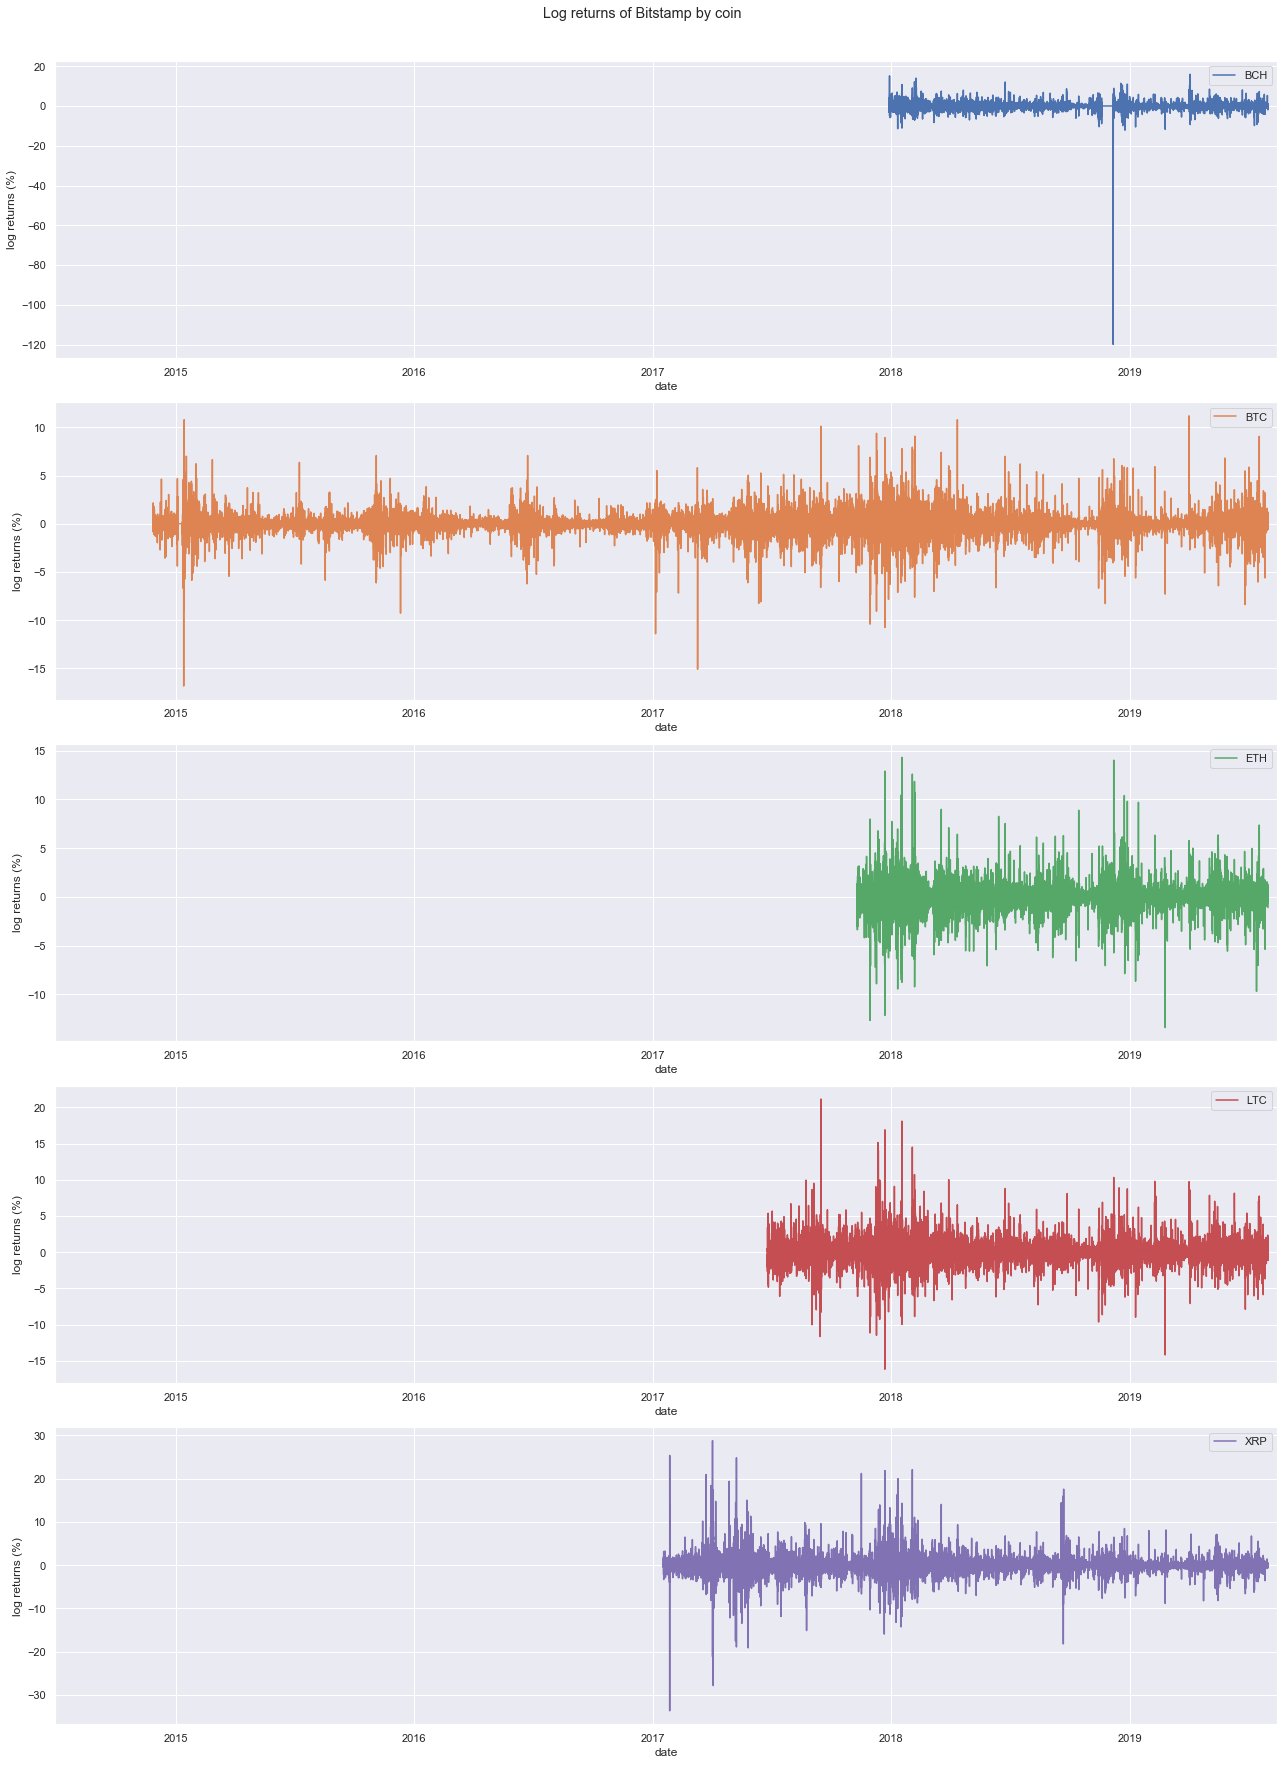

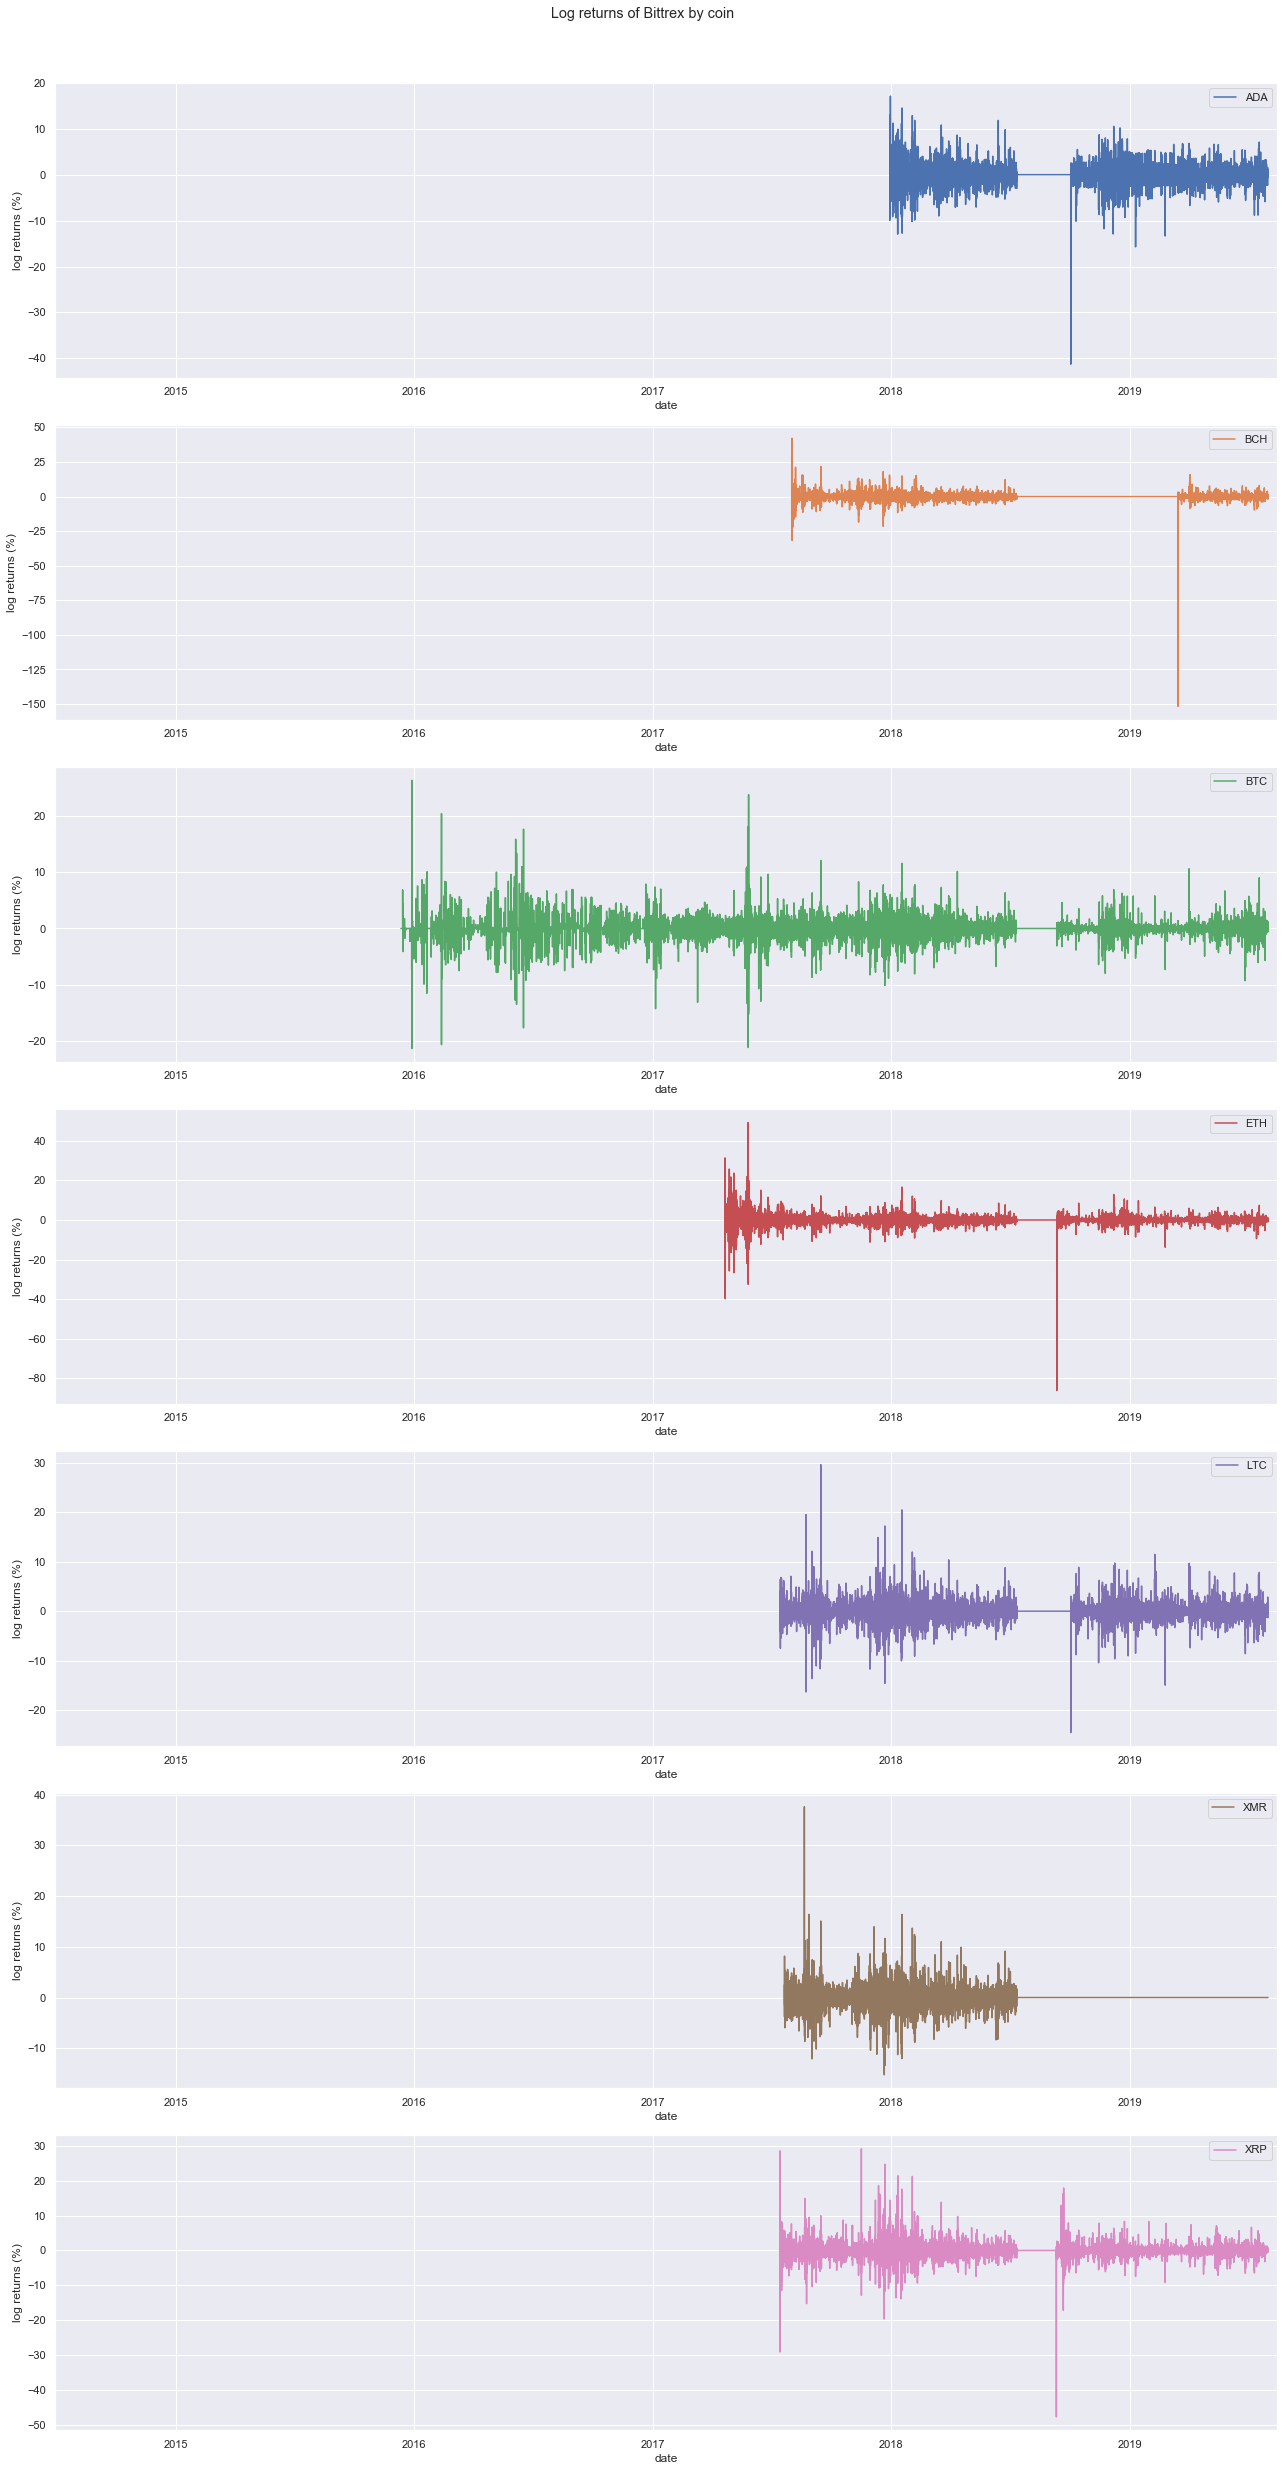

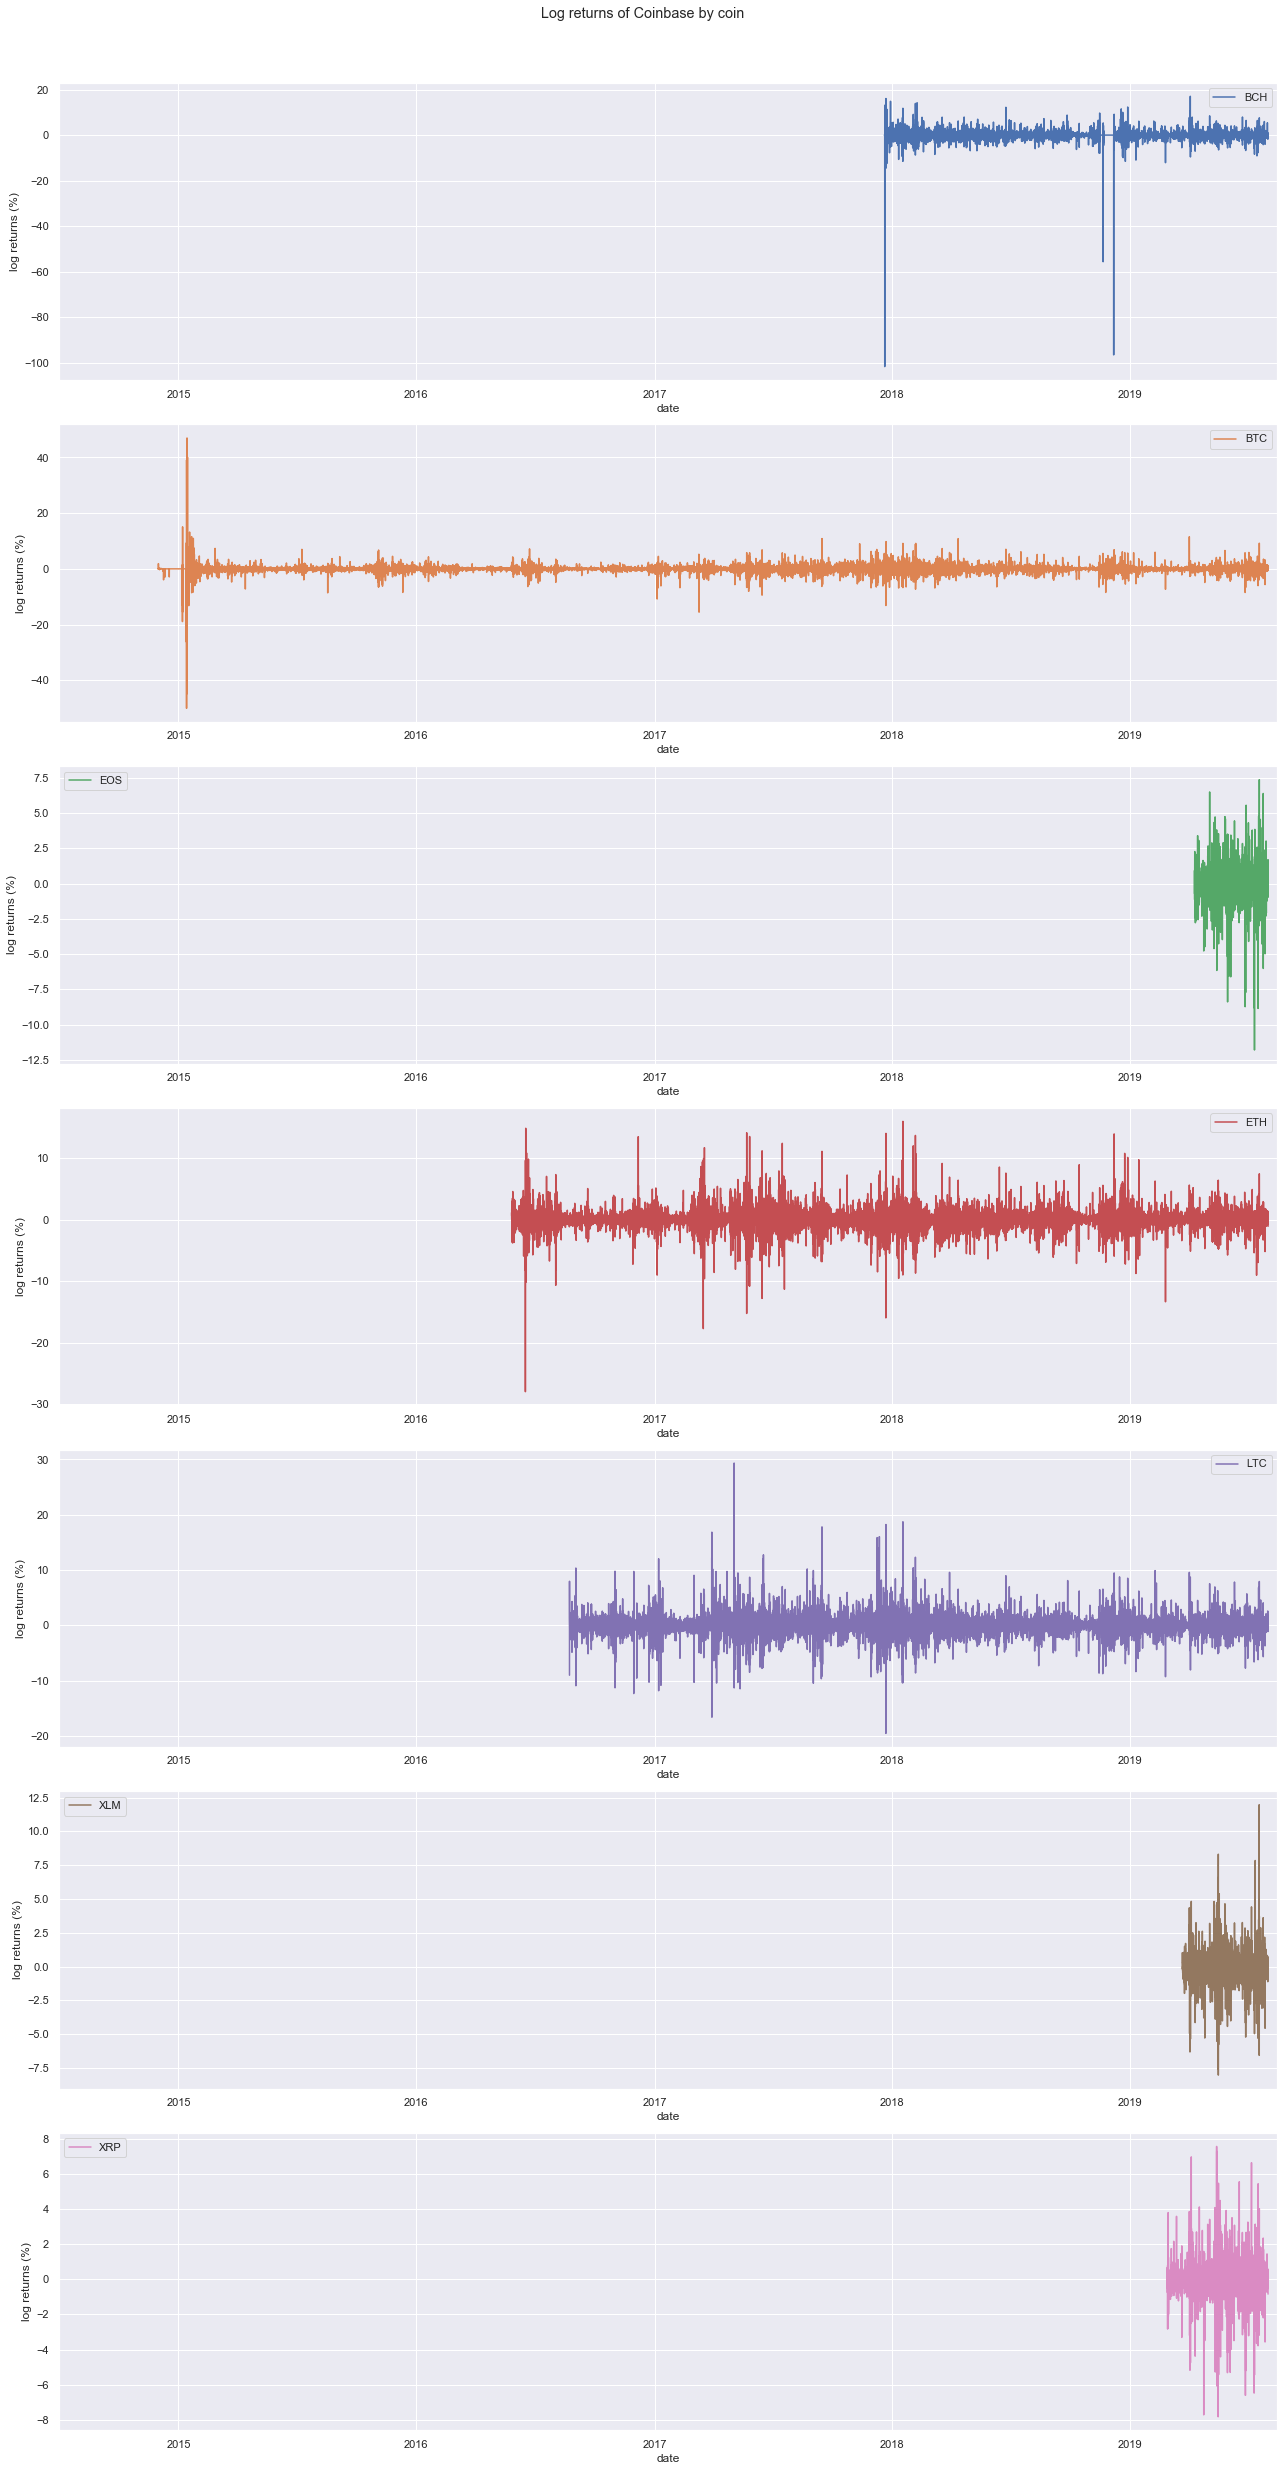

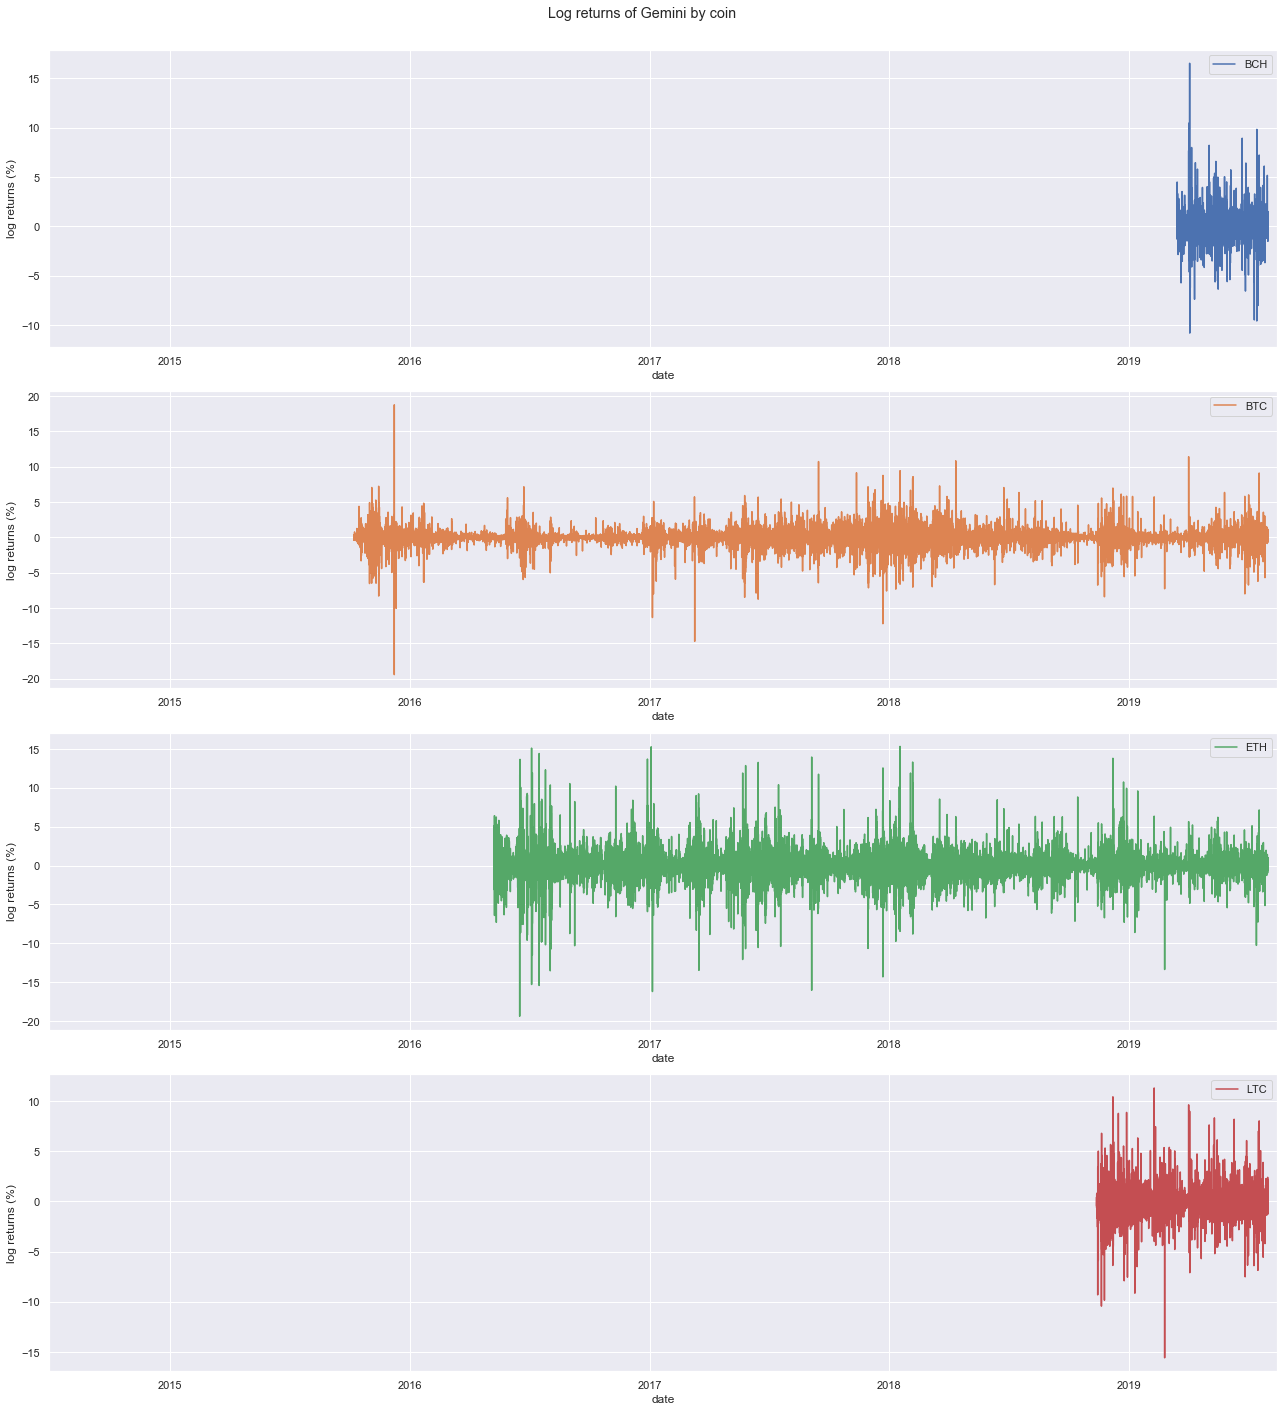

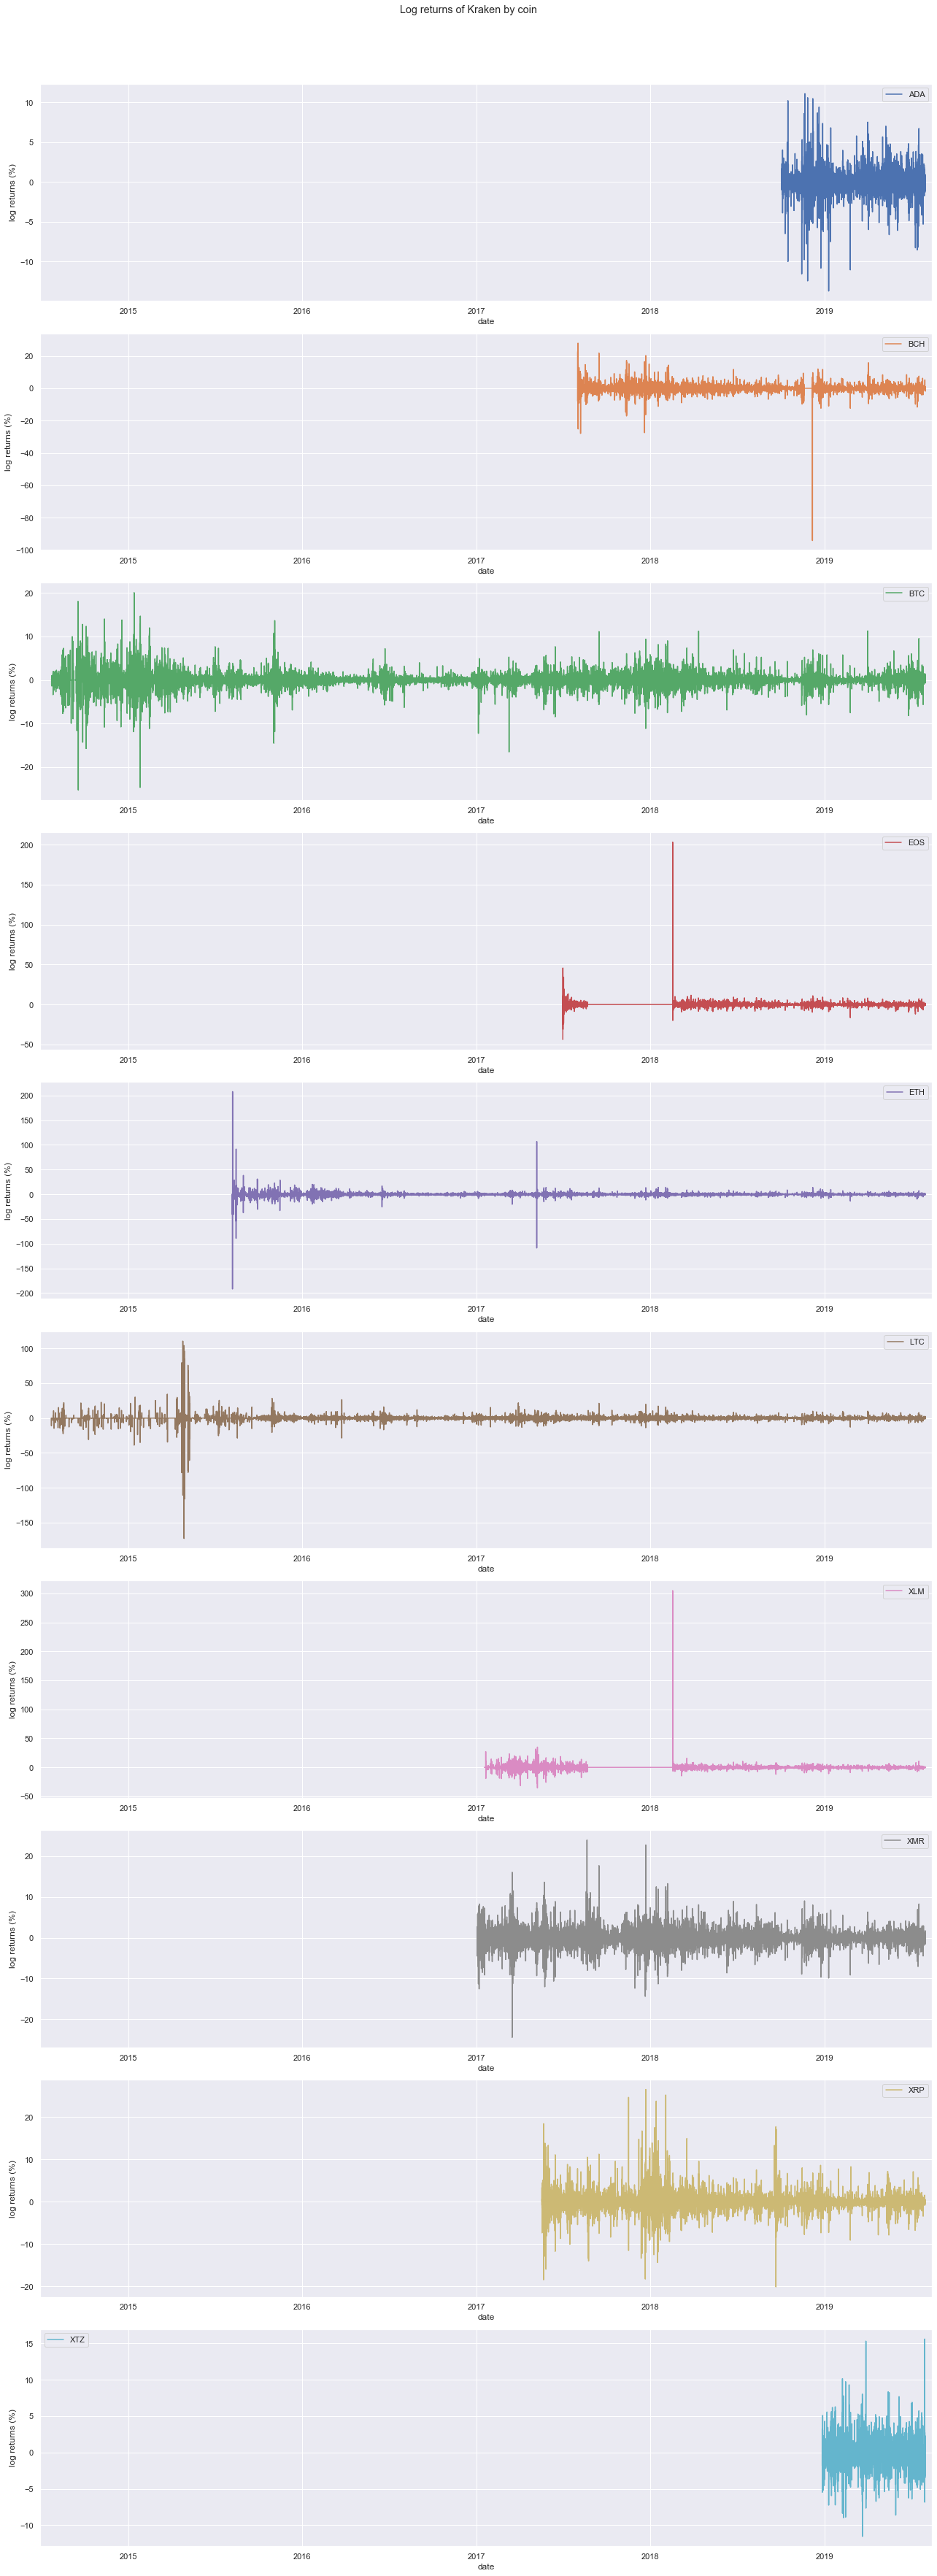

CPU times: user 32.9 s, sys: 1.29 s, total: 34.2 s
Wall time: 41.1 s


In [13]:
%%time

plot_log_returns_by_exchange(df_returns)

#### 5. Similar to the factor project, see if you can construct a ML trading model that exploits lead-lag relationships. Explain whether you think this is viable for a hedge fund or other type of trader.

We use BTC and ETH, the most popular/well-known/largest by market cap cryptocurrencies to construct two trading strategies: 1) traditional MA strategy, and 2) random forest strategy. We choose 7 lags, rather than 5 lags, for our moving average, as cryptocurrencies are a 24/7 market. Similarly, we use the previous 7 days' log returns in fitting our random forest model.

For our traditional MA(7) strategy, we create a "buy" signal if the average of the previous 7 days' log returns is above the previous days' log returns, and a "sell" signal otherwise. Similarly, if our random forest model predicts a price that is above the previous day's price, we record a "buy" signal and a "sell" signal otherwise.

In addition to comparing the performance of our strategies against the performance an investment in the underlying cryptocurrency, we also compare the strategies' performance to the performance of an investment in the S&P 500 (representing the market), the VIX (representing volatility), gold (representing a classic store of value), and the EURUSD (representing a traditional currency).

Our results from the MA(7) strategy achieved cumulative returns of ~80% for BTC and ~10% for ETH at the end of the sample. Both strategies were found to outperform the baseline investments. Despite an investment in the underlying ETH to be the worst performing, the ETH MA(7) strategy performed the second best overall.

The random forest model unfortunately did not fare quite as well. The BTC strategy outperformed the investment in the underlying BTC for part of the test set before a trend shift, with the BTC strategy ending up underperforming against a direct investment in BTC. Results for the ETH random forest strategy were similar to, and slightly worse than, those of the random forest BTC strategy.

We conclude that the ML trading model is not viable for a hedge fund or other type of trader as it resulted in worse returns than investing in the underlying cryptocurrencies themselves.

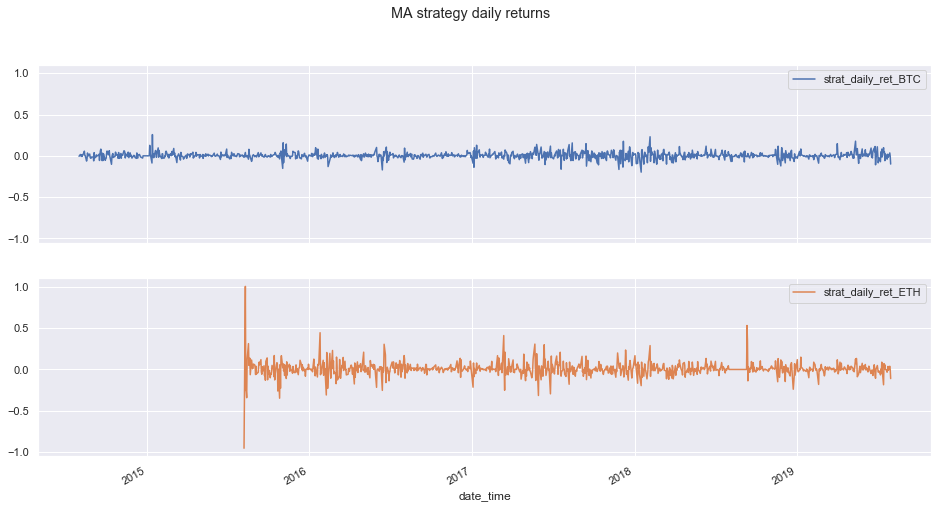

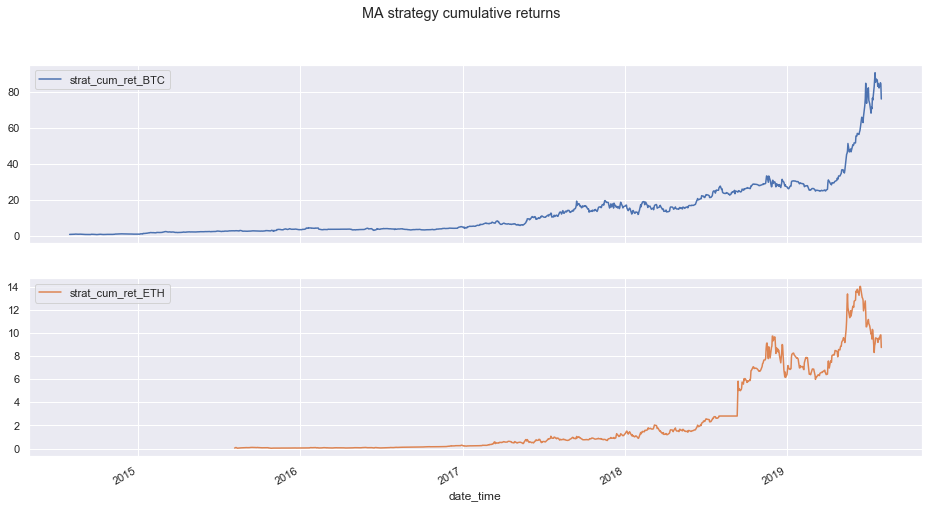

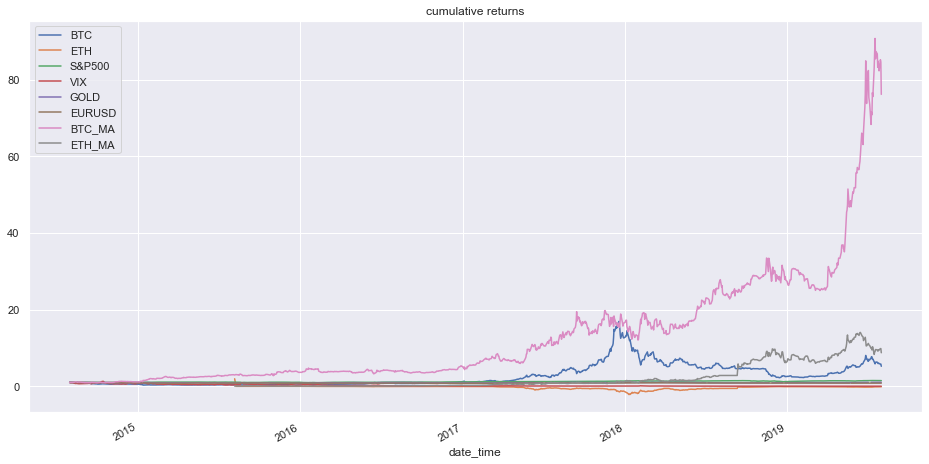

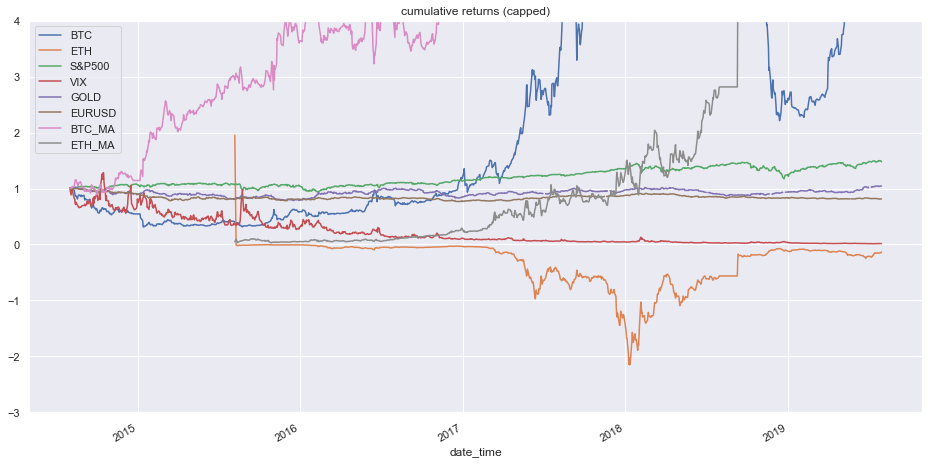

CPU times: user 3.11 s, sys: 117 ms, total: 3.23 s
Wall time: 3.83 s


In [14]:
%%time

# we look at BTC and ETH (most popular/well-known/largest cryptocurrencies);
# from hw1, we use a traditional MA stategy as well as a random forest strategy;
# we compare to 1) investing in the S&P500 ("market")
#               2) investing in the VIX ("volatility")
#               3) investing in gold ("store of value") 
#               4) investing in EURUSD ("most liquid ccy pair")
# sorry this code is messy!

lag = 7

df_sp500 = read_and_prep_csv('S&P500')
df_vix = read_and_prep_csv('VIX')
df_gold = read_and_prep_csv('GOLD')
df_eurusd = read_and_prep_csv('EURUSD')

df_btc = df[df['Coin']=='BTC'][['date_time','close']]
df_eth = df[df['Coin']=='ETH'][['date_time','close']]

# define closiing price (per hr) as highest close across all 5 exchanges
df_btc = df_btc.groupby('date_time').max().reset_index().rename(columns={'close':'BTC'})
df_eth = df_eth.groupby('date_time').max().reset_index().rename(columns={'close':'ETH'})

df_close = df_btc.merge(df_eth, on='date_time')
df_close = df_close.set_index('date_time').resample('D').sum().reset_index()
df_close = df_close.merge(df_sp500, on='date_time')\
                   .merge(df_vix, on='date_time')\
                   .merge(df_gold, on='date_time')\
                   .merge(df_eurusd, on='date_time')
df_close = df_close.set_index('date_time')
df_logret = np.log(df_close / df_close.shift(1))
# 'ETH' is inf on '2015-08-06'
df_logret = df_logret.replace(np.inf, np.nan)

df_logret['lag_BTC'] = df_logret['BTC'].shift(1)
df_logret['lag_ETH'] = df_logret['ETH'].shift(1)
df_logret['MA_BTC'] = df_logret['lag_BTC'].rolling(lag).mean()
df_logret['MA_ETH'] = df_logret['lag_ETH'].rolling(lag).mean()
# Buy if the previous day's return was above the 5-day moving average
df_logret['signal_BTC'] = (df_logret['lag_BTC'] > df_logret['MA_BTC']).astype(int) * 2 - 1
df_logret['signal_ETH'] = (df_logret['lag_ETH'] > df_logret['MA_ETH']).astype(int) * 2 - 1
df_logret = df_logret.iloc[lag:,:]

df_logret['strat_daily_ret_BTC'] = df_logret['signal_BTC'] * df_logret['BTC']
df_logret['strat_daily_ret_ETH'] = df_logret['signal_ETH'] * df_logret['ETH']
df_logret['strat_cum_ret_BTC'] = (df_logret['strat_daily_ret_BTC'] + 1).cumprod()
df_logret['strat_cum_ret_ETH'] = (df_logret['strat_daily_ret_ETH'] + 1).cumprod()

df_logret[['strat_daily_ret_BTC','strat_daily_ret_ETH']].plot(figsize=(16,8),
                                                              subplots=True,
                                                              sharey=True,
                                                              title='MA strategy daily returns')
plt.show()

df_logret[['strat_cum_ret_BTC','strat_cum_ret_ETH']].plot(figsize=(16,8),
                                                              subplots=True,
                                                              title='MA strategy cumulative returns')
plt.show()

df_cumret = (df_logret[['BTC','ETH','S&P500','VIX','GOLD','EURUSD']] + 1.).cumprod()
df_cumret['BTC_MA'] = df_logret['strat_cum_ret_BTC']
df_cumret['ETH_MA'] = df_logret['strat_cum_ret_ETH']

df_cumret.plot(figsize=(16,8),
               title='cumulative returns')
plt.show()

df_cumret.plot(figsize=(16,8),
               ylim=(-3,4),
               title='cumulative returns (capped)')
plt.show()

BTC   BTC_t-1   BTC_t-2   BTC_t-3   BTC_t-4   BTC_t-5  \
date_time                                                                
2014-08-12 -0.039269 -0.025780 -0.006505  0.010647  0.007140 -0.011946   
2014-08-13 -0.056487 -0.039269 -0.025780 -0.006505  0.010647  0.007140   
2014-08-14 -0.006008 -0.056487 -0.039269 -0.025780 -0.006505  0.010647   
2014-08-15  0.000874 -0.006008 -0.056487 -0.039269 -0.025780 -0.006505   
2014-08-18 -0.063458  0.000874 -0.006008 -0.056487 -0.039269 -0.025780   

             BTC_t-6   BTC_t-7   rf_pred  signal  
date_time                                         
2014-08-12 -0.016160  0.005622 -0.027445      -1  
2014-08-13 -0.011946 -0.016160 -0.036879       1  
2014-08-14  0.007140 -0.011946 -0.005916       1  
2014-08-15  0.010647  0.007140  0.005587       1  
2014-08-18 -0.006505  0.010647 -0.045257      -1

Random forest regression training MSE: 0.0002464029731763055
Random forest regression test MSE: 0.0015794637984297552


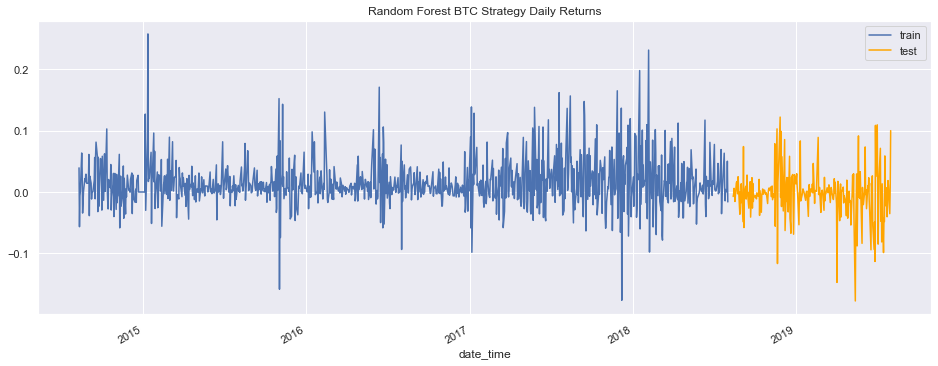

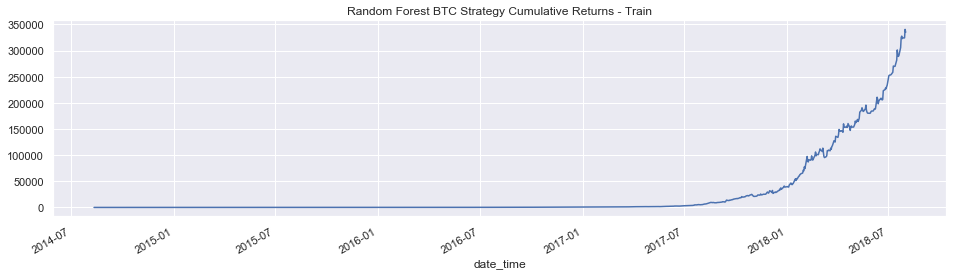

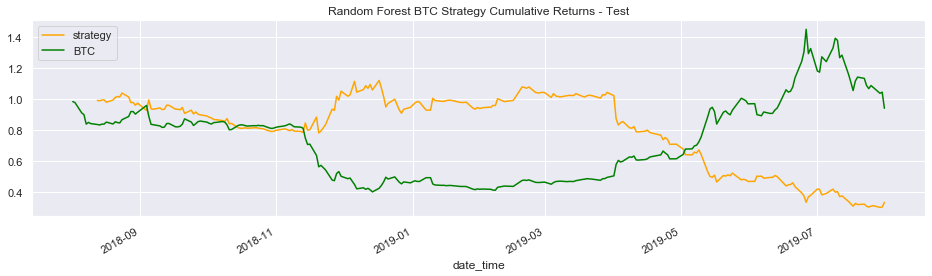

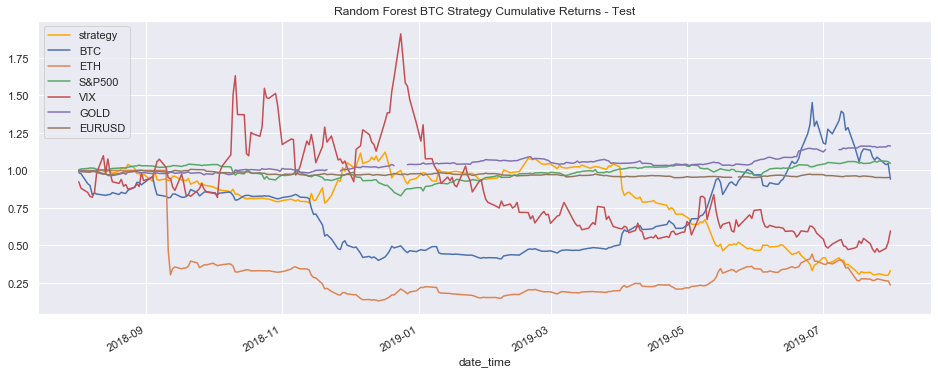

ETH   ETH_t-1   ETH_t-2   ETH_t-3   ETH_t-4   ETH_t-5  \
date_time                                                                
2015-08-18 -0.050054 -0.312901 -0.119252  0.341871  0.265341  0.245736   
2015-08-19  0.081063 -0.050054 -0.312901 -0.119252  0.341871  0.265341   
2015-08-20  0.137074  0.081063 -0.050054 -0.312901 -0.119252  0.341871   
2015-08-21 -0.063308  0.137074  0.081063 -0.050054 -0.312901 -0.119252   
2015-08-24 -0.114473 -0.063308  0.137074  0.081063 -0.050054 -0.312901   

             ETH_t-6   ETH_t-7   rf_pred  signal  
date_time                                         
2015-08-18 -1.005484  0.953128 -0.036876       1  
2015-08-19  0.245736 -1.005484  0.055981       1  
2015-08-20  0.265341  0.245736  0.102540       1  
2015-08-21  0.341871  0.265341 -0.007057      -1  
2015-08-24 -0.119252  0.341871 -0.068425      -1

Random forest regression training MSE: 0.0008648467288764006
Random forest regression test MSE: 0.004169573579056717


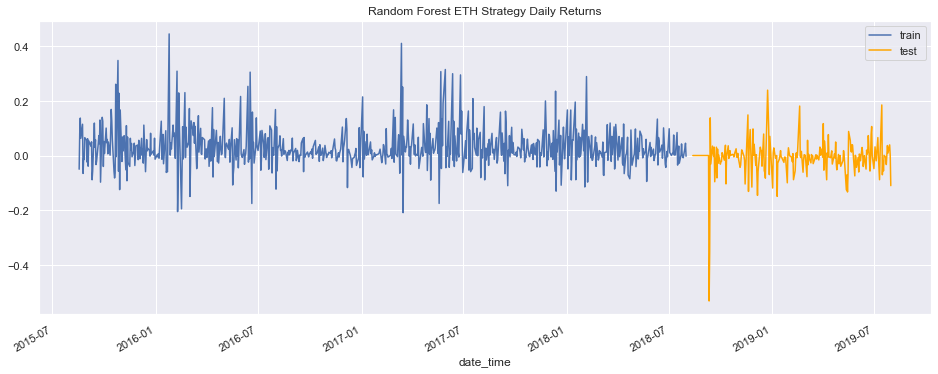

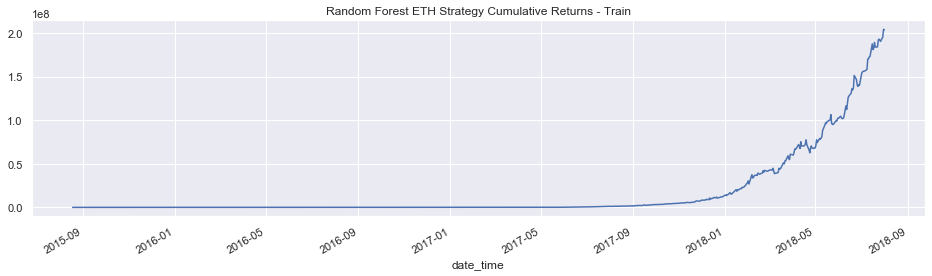

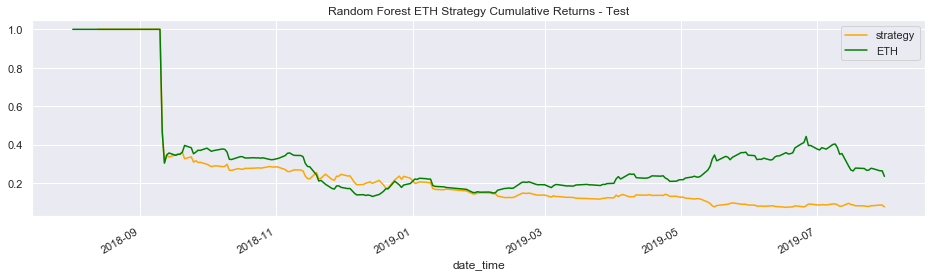

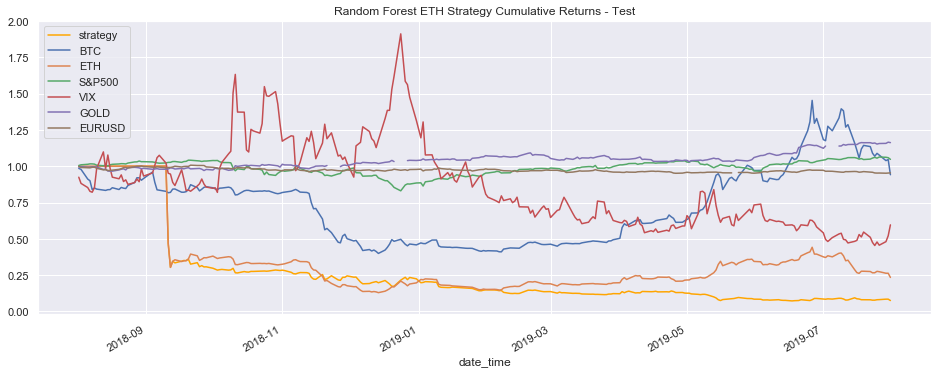

CPU times: user 5.19 s, sys: 190 ms, total: 5.38 s
Wall time: 7.02 s


In [15]:
%%time

train_end = df_logret.index.min() + pd.DateOffset(years=4)

df_train = df_logret[df_logret.index <= train_end]
df_test = df_logret[df_logret.index > train_end]

print_rf_results(df_train, df_test, 'BTC', nlags=7)
print_rf_results(df_train, df_test, 'ETH', nlags=7)

#### 6. Use ML techniques to identify any observable patterns in the trading data. For example, you may look for patterns by time of day (e.g., Asia trading hours), day of week (e.g., weekends vs. weekdays), trade size, etc. Are there any robust findings that you can detect for the largest 5 cryptocurrencies?

We visually inspect the time series of the largest five cryptocurrencies by market cap: BTC, ETH, LTC, XRP, and BCH. A one-week sample (Sun to Sat) of hourly volume as the sum of volume across all exchanges shows that there appear to be daily patterns and spikes. These likely correspond to peak trading in the Asian, European, and North American markets. We similarly look at a four-week sample and note that the daily spikes appear to persist.

Plotting the sum of the volume of the five cryptocurrencies for each of the five exchanges, we see volume spike alignment, which lends credibility to the validity of the reported volumes on the exchanges.

In [16]:
%%time

# largest 5 cryptocurrencies by total volume over entire sample
top5 = df.groupby('Coin').agg({'volume':'sum'}).sort_values('volume', ascending=False).head(5)
top5

CPU times: user 140 ms, sys: 28.5 ms, total: 168 ms
Wall time: 206 ms


volume
Coin              
BTC   2.428650e+11
ETH   9.540162e+10
LTC   3.951728e+10
XRP   2.075190e+10
BCH   1.849243e+10

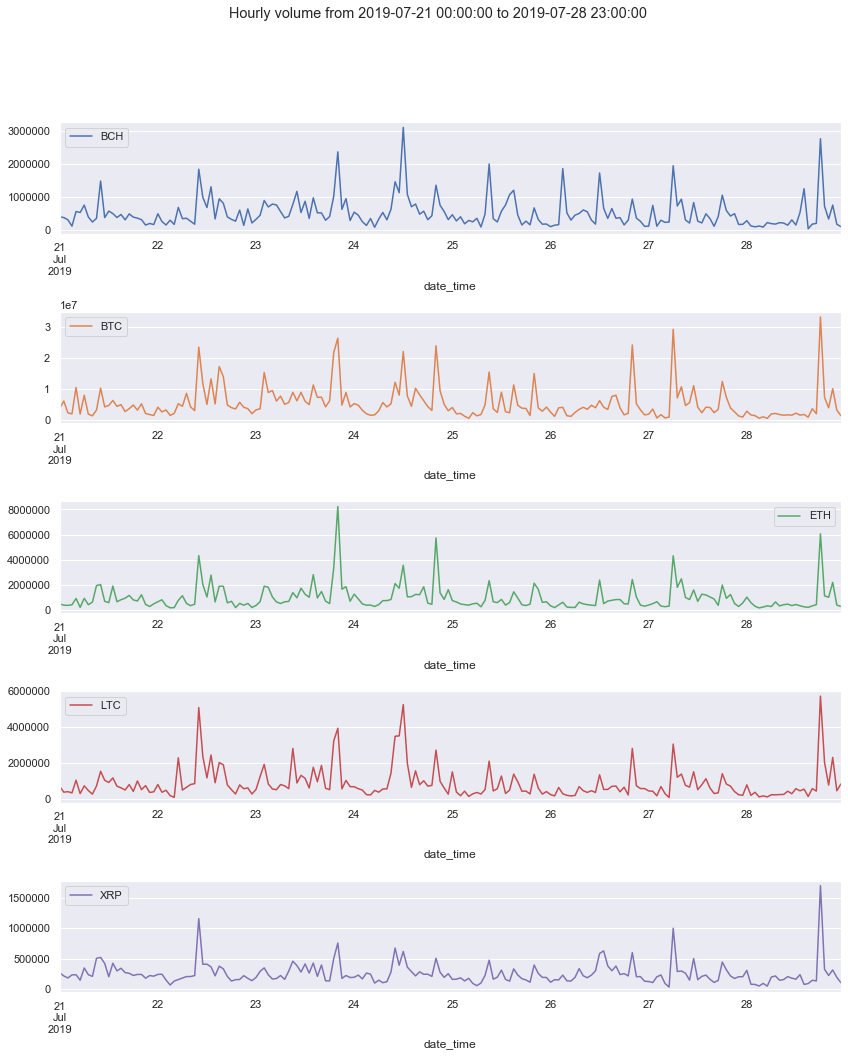

CPU times: user 1.6 s, sys: 65 ms, total: 1.67 s
Wall time: 1.95 s


In [17]:
%%time

# Notes: global markets, Asia (Hong Kong, 9:30am - 4pm GMT+08:00) 
#                    vs. Europe (London, 8:00am - 4:30pm GMT+00:00) 
#                    vs. North America (NY, 9:30am - 4pm GMT-05:00)

# one week sample (Sun to Sat)
plot_top5_coinbase_volume(df, top5.index, '2019-07-21 00:00:00', '2019-07-28 23:00:00')

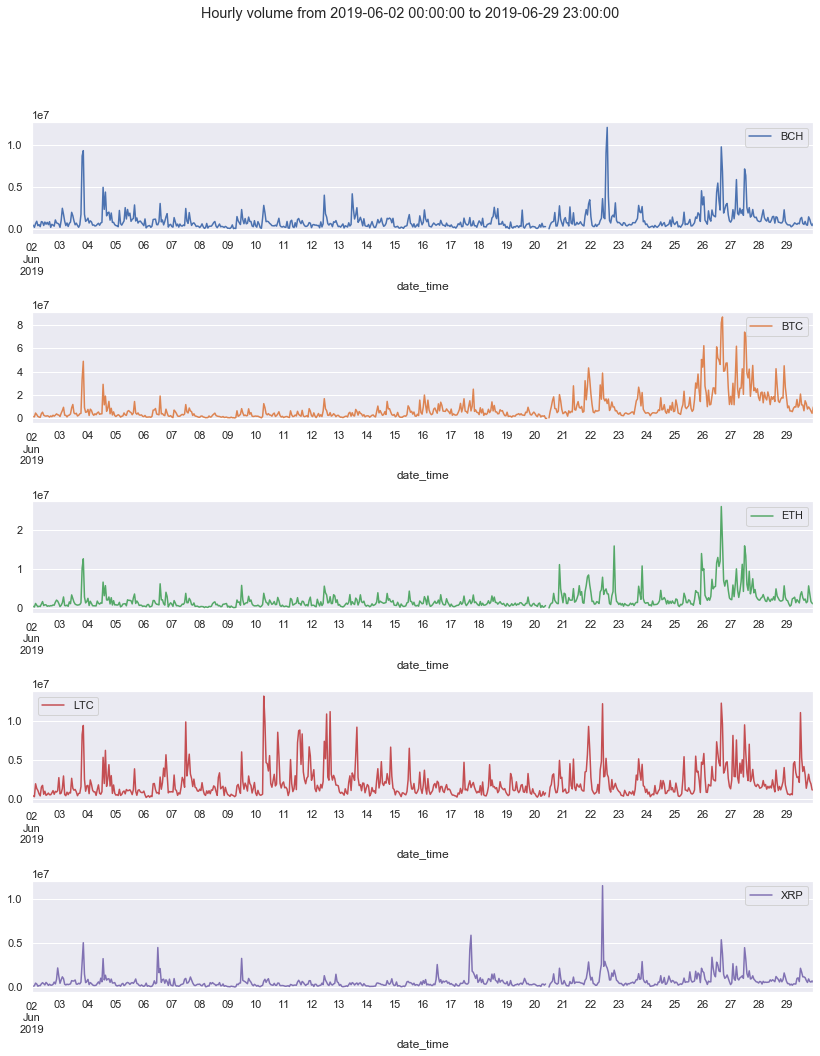

CPU times: user 2.56 s, sys: 83.6 ms, total: 2.65 s
Wall time: 2.72 s


In [18]:
%%time

# a 4-wk sample (Sun to Sat)
plot_top5_coinbase_volume(df, top5.index, '2019-06-02 00:00:00', '2019-06-29 23:00:00')

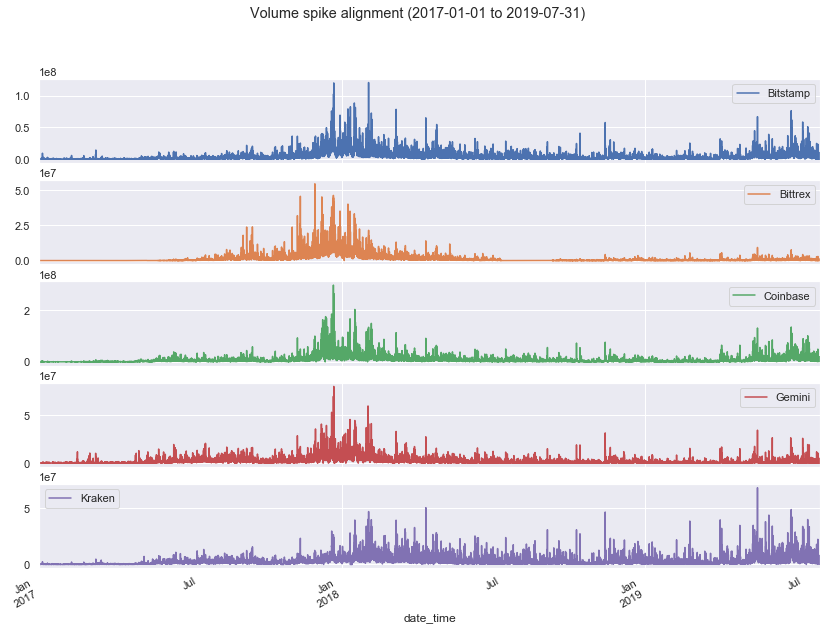

CPU times: user 2.89 s, sys: 232 ms, total: 3.12 s
Wall time: 3.09 s


In [21]:
%%time

# volume spike alignment

df[(df['Coin'].isin(top5.index)) &
   (df['date_time'] >= '2017-01-01 00:00')][['date_time','Exchange','volume']].groupby(['date_time','Exchange'])\
                                                                    .sum()\
                                                                    .reset_index()\
                                                                    .pivot(index='date_time',
                                                                           columns='Exchange',
                                                                           values='volume')\
                                                                    .plot(figsize=(14,10),
                                                                          subplots=True,
                                                                          title='Volume spike alignment (2017-01-01 to 2019-07-31)')
plt.show()

#### 7. What can you conclude given your mandate and the tight schedule for reporting to senior management? Explain clearly and succinctly in the form of a memo to your senior management. (Keep it brief please to 1 page).

(see separate memo)

#### 8. Per exchange, calculate the first significant digit distribution. What inference do you draw?

According to Benford's law, the leading digit will be $d$ with probability: $\log_{10} (1 + 1/d)$. In plotting the actual versus the Benford count distributions, it appears that the total volume (sum of volume of all ten cryptocurrencies) reported approximately follows the theoretical Benford distribution. 

To investigate further, we run a chi-square goodness of fit test for each exchange. The null hypothesis, $H_0$, assumes that there is no difference between the expected and observed leading digit counts, while the alternative hypothesis, $H_1$, is that there is a (statistically) significant difference between the two distributions.

The results of our chi-square goodness of fit tests showed that we reject $H_0$ for both Coinbase and Gemini. This suggests that the self-reported volumes for Coinbase and Gemini may have been faked or fraudulent.

We conclude that we should be wary of trading on Coinbase and Gemini due to potential market manipulation.

/Users/reneereynolds/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:622: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Chi-square goodness of fit test for Bitstamp:

p value is 0.15420229784755196
Independent (H0 holds true)


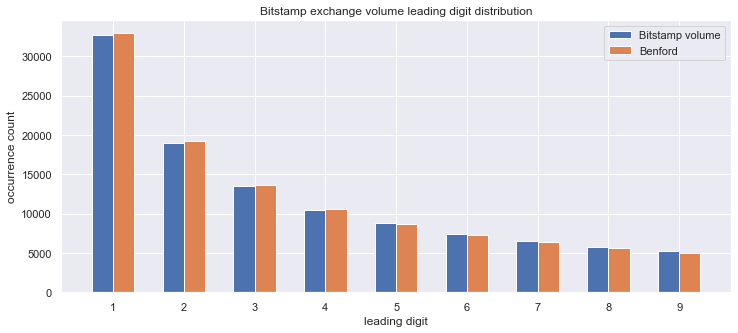

Chi-square goodness of fit test for Bittrex:

p value is 0.7813442111660636
Independent (H0 holds true)


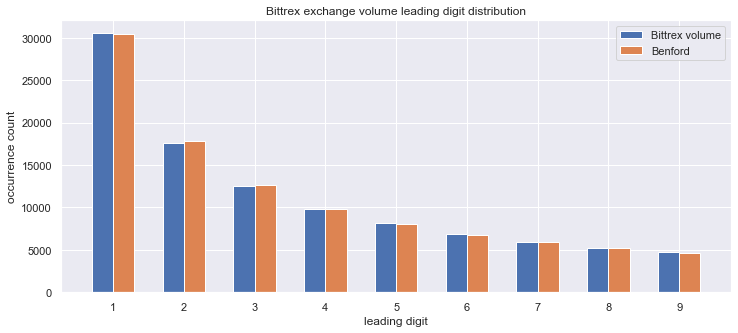

Chi-square goodness of fit test for Coinbase:

p value is 1.3430761815799791e-20
Dependent (reject H0)


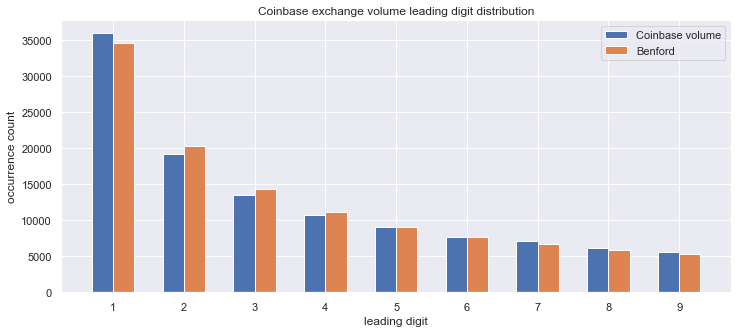

Chi-square goodness of fit test for Gemini:

p value is 0.032107636824291505
Dependent (reject H0)


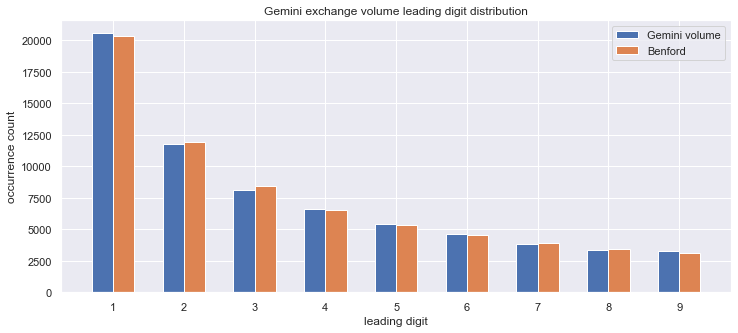

Chi-square goodness of fit test for Kraken:

p value is 0.13032721569547895
Independent (H0 holds true)


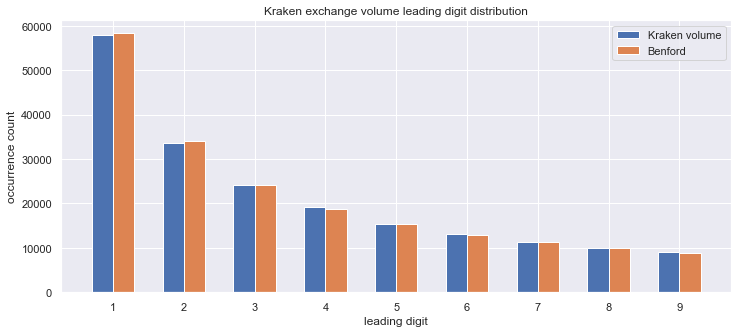

CPU times: user 3.38 s, sys: 251 ms, total: 3.63 s
Wall time: 3.84 s


In [20]:
%%time

df_volume = df[['Exchange','volume']].dropna()
wrapper_plot_benford_counts(df_volume)